# About this notebook  

TBD...

# Data Loading

In [1]:
import os

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
os.listdir("../input/cassava-leaf-disease-classification")

['label_num_to_disease_map.json',
 'sample_submission.csv',
 'train_tfrecords',
 'test_tfrecords',
 'test_images',
 'train_images',
 'train.csv']

In [3]:
# train = pd.read_csv("../input/cassava-leaf-disease-classification/train.csv")
# train = pd.read_csv("../input/cassava-leaf-disease-merged/oversample-0124.csv")  # label 0124 x3

train_id = pd.read_csv("../input/cassava-leaf-disease-merged/merged.csv")["image_id"]
dist = pd.read_csv("distillation_label/ensemble-tta-v2.csv", header=None)
train_label = pd.DataFrame(dist.idxmax(axis=1), columns=["label"])
train = pd.concat([train_id, train_label, dist], axis=1)

test = pd.read_csv("../input/cassava-leaf-disease-classification/sample_submission.csv")
label_map = pd.read_json("../input/cassava-leaf-disease-classification/label_num_to_disease_map.json", orient="index")

display(train.head())
display(test.head())
display(label_map)

,image_id,label,0,1,2,3,4
0,1000015157.jpg,0,0.366398,0.208276,0.242890,0.032828,0.149609
1,1000201771.jpg,3,0.026702,0.035673,0.048356,0.855284,0.033985
2,100042118.jpg,4,0.035391,0.181462,0.055520,0.092377,0.635250
3,1000723321.jpg,1,0.024406,0.812886,0.036725,0.068673,0.057310
4,1000812911.jpg,3,0.028928,0.030277,0.029193,0.879340,0.032262


,image_id,label
0,2216849948.jpg,4


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


/home/ubuntu/work/pytorch/.venv/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='label'>

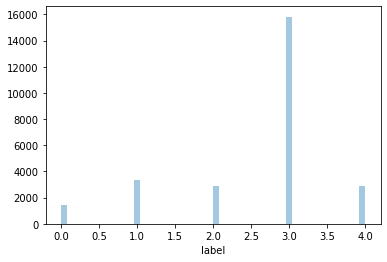

In [4]:
sns.distplot(train["label"], kde=False)

# Directory settings

In [5]:
# ====================================================
# Directory settings
# ====================================================
import os

OUTPUT_DIR = "./"
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# TRAIN_PATH = "../input/cassava-leaf-disease-classification/train_images"
TRAIN_PATH = "../input/cassava-leaf-disease-merged/train"
TEST_PATH = "../input/cassava-leaf-disease-classification/test_images"

# CFG

In [6]:
# ====================================================
# CFG
# ====================================================
class CFG:
    debug = False
    apex = False
    print_freq = 100
    num_workers = 4
    model_name = "tf_efficientnet_b4_ns"  # resnext50_32x4d, seresnext50_32x4d, tf_efficientnet_b3_ns, vit_base_patch16_384, deit_base_patch16_384
    batch_size = 8
    gradient_accumulation_steps = 4
    size = 384 if "it_base_" in model_name else 512
    n_fold = 5
    trn_fold = [0, 1, 2, 3, 4]
    criterion = "BiTemperedLoss"  # ['CrossEntropyLoss', 'BiTemperedLoss']
    btl_t1 = 0.3  # Bi-Tempered Logistic Loss
    btl_t2 = 1.0
    label_smoothing = 0.2
    kd_temperature = 10  # DistillationLoss
    kd_alpha = 0.9  # DistillationLoss
    scheduler = "CosineAnnealingWarmRestarts"  # ['ReduceLROnPlateau', 'CosineAnnealingLR', 'CosineAnnealingWarmRestarts', 'CosineAnnealingWarmupRestarts']
    scheduler_batch_update = True
    epochs = 10
    # factor = 0.2  # ReduceLROnPlateau
    # patience = 4  # ReduceLROnPlateau
    # eps = 1e-6  # ReduceLROnPlateau
    # T_max = 10  # CosineAnnealingLR
    T_0 = (
        len(train) // n_fold * (n_fold - 1) // batch_size // gradient_accumulation_steps * epochs + 5
    )  # CosineAnnealingWarmRestarts
    # first_cycle_steps = (
    #     len(train) // n_fold * (n_fold - 1) // batch_size // gradient_accumulation_steps * epochs + 5
    # )  # CosineAnnealingWarmupRestarts for batch update
    # warmup_steps = first_cycle_steps // 10  # CosineAnnealingWarmupRestarts
    # gamma = 0.8  # CosineAnnealingWarmupRestarts
    lr = 1e-4
    min_lr = 2e-6
    weight_decay = 1e-6
    max_grad_norm = 1000
    seed = 5345
    target_size = 5
    target_col = "label"
    train = True
    inference = False


if CFG.debug:
    CFG.epochs = 1
    train = train.sample(n=1000, random_state=CFG.seed).reset_index(drop=True)

# Library

In [7]:
# ====================================================
# Library
# ====================================================
import sys

sys.path.append("../input/pytorch-image-models/pytorch-image-models-master")
sys.path.append("../input/pytorchcosineannealingwithwarmup")
sys.path.append("../input/bitemperedlogloss/")
sys.path.append("../input/image-fmix/FMix-master")

import math
import os
import random
import shutil
import time
import warnings
from collections import Counter, defaultdict
from contextlib import contextmanager
from functools import partial
from pathlib import Path

import bi_tempered_loss_pytorch as btl
import cv2
import numpy as np
import pandas as pd
import scipy as sp
import timm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from albumentations import (
    CenterCrop,
    CoarseDropout,
    Compose,
    Cutout,
    HorizontalFlip,
    HueSaturationValue,
    IAAAdditiveGaussianNoise,
    ImageOnlyTransform,
    Normalize,
    OneOf,
    RandomBrightness,
    RandomBrightnessContrast,
    RandomContrast,
    RandomCrop,
    RandomResizedCrop,
    Resize,
    Rotate,
    ShiftScaleRotate,
    Transpose,
    VerticalFlip,
)
from albumentations.pytorch import ToTensorV2
from cosine_annearing_with_warmup import CosineAnnealingWarmupRestarts
from fmix import sample_mask
from PIL import Image
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from torch.nn.parameter import Parameter
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import CosineAnnealingLR, CosineAnnealingWarmRestarts, ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from tqdm.auto import tqdm

warnings.filterwarnings("ignore")

if CFG.apex:
    from apex import amp

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Utils

In [8]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    return accuracy_score(y_true, y_pred)


@contextmanager
def timer(name):
    t0 = time.time()
    LOGGER.info(f"[{name}] start")
    yield
    LOGGER.info(f"[{name}] done in {time.time() - t0:.0f} s.")


def init_logger(log_file=OUTPUT_DIR + "train.log"):
    from logging import INFO, FileHandler, Formatter, StreamHandler, getLogger

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger


LOGGER = init_logger()


def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_torch(seed=CFG.seed)

# CV split

In [9]:
folds = train.copy()
Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
for n, (train_index, val_index) in enumerate(Fold.split(folds, folds[CFG.target_col])):
    folds.loc[val_index, "fold"] = int(n)
folds["fold"] = folds["fold"].astype(int)
print(folds.groupby(["fold", CFG.target_col]).size())

fold  label
0     0         289
      1         663
      2         578
      3        3165
      4         573
1     0         289
      1         663
      2         578
      3        3165
      4         573
2     0         289
      1         663
      2         577
      3        3165
      4         573
3     0         288
      1         662
      2         578
      3        3166
      4         573
4     0         288
      1         663
      2         578
      3        3165
      4         573
dtype: int64


# Dataset

In [10]:
# ====================================================
# Dataset
# ====================================================
class TrainDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.hard_target = df["label"].values
        self.soft_target = df[[0, 1, 2, 3, 4]].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TRAIN_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        hard_target = torch.tensor(self.hard_target[idx]).long()
        soft_target = torch.tensor(self.soft_target[idx]).float()
        return image, hard_target, soft_target


class TestDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.file_names = df["image_id"].values
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.file_names[idx]
        file_path = f"{TEST_PATH}/{file_name}"
        image = cv2.imread(file_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]
        return image

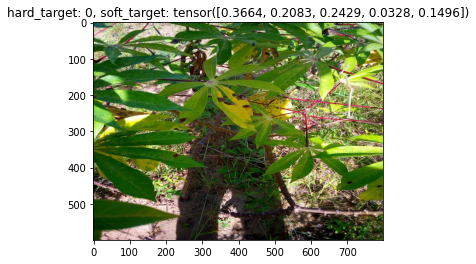

In [11]:
train_dataset = TrainDataset(train, transform=None)

for i in range(1):
    image, hard_target, soft_target = train_dataset[i]
    plt.imshow(image)
    plt.title(f"hard_target: {hard_target}, soft_target: {soft_target}")
    plt.show()

# Transforms

In [12]:
# ====================================================
# Transforms
# ====================================================
def get_transforms(*, data):

    if data == "train":
        return Compose(
            [
                # Resize(CFG.size, CFG.size),
                RandomResizedCrop(CFG.size, CFG.size),
                Transpose(p=0.5),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                ShiftScaleRotate(p=0.5),
                HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                RandomBrightnessContrast(brightness_limit=(-0.1, 0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                CoarseDropout(p=0.5),
                Cutout(p=0.5),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

    elif data == "valid":
        return Compose(
            [
                Resize(CFG.size, CFG.size),
                CenterCrop(CFG.size, CFG.size),
                Normalize(
                    mean=[0.485, 0.456, 0.406],
                    std=[0.229, 0.224, 0.225],
                ),
                ToTensorV2(),
            ]
        )

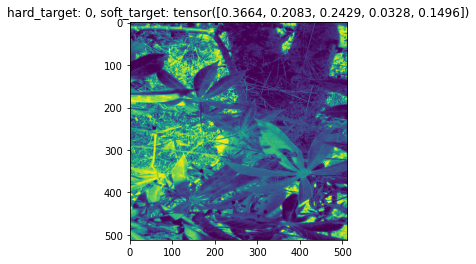

In [13]:
train_dataset = TrainDataset(train, transform=get_transforms(data="train"))

for i in range(1):
    image, hard_target, soft_target = train_dataset[i]
    plt.imshow(image[0])
    plt.title(f"hard_target: {hard_target}, soft_target: {soft_target}")
    plt.show()

# CutMix / FMix


In [14]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1.0 - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2


def cutmix(data, target, soft_target, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_target = target[indices]
    shuffled_soft_target = soft_target[indices]

    lam = np.clip(np.random.beta(alpha, alpha), 0.3, 0.4)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    new_data = data.clone()
    new_data[:, :, bby1:bby2, bbx1:bbx2] = data[indices, :, bby1:bby2, bbx1:bbx2]
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))
    targets = (target, soft_target, shuffled_target, shuffled_soft_target, lam)

    return new_data, targets


def fmix(data, targets, soft_target, alpha, decay_power, shape, max_soft=0.0, reformulate=False):
    lam, mask = sample_mask(alpha, decay_power, shape, max_soft, reformulate)
    if CFG.apex:
        # mask = torch.tensor(mask, device=device).float()
        mask = mask.astype(np.float32)
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets = targets[indices]
    shuffled_soft_target = soft_target[indices]
    x1 = torch.from_numpy(mask).to(device) * data
    x2 = torch.from_numpy(1 - mask).to(device) * shuffled_data
    targets = (targets, soft_target, shuffled_targets, shuffled_soft_target, lam)

    return (x1 + x2), targets

# MixUp

In [15]:
# https://github.com/yuhao318/mwh/blob/e9e2da8fc6/utils.py
def mixup(x, y, soft_target, alpha=1.0, use_cuda=True):

    """Compute the mixup data. Return mixed inputs, pairs of targets, and lambda"""
    if alpha > 0.0:
        lam = np.random.beta(alpha, alpha)
        lam = max(lam, 1 - lam)
        # lam = min(lam, 1-lam)
    else:
        lam = 1.0
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    ## SYM
    # mixed_x = lam * x + (1 - lam) * x[index,:]
    # mixed_y = (1 - lam) * x + lam * x[index,:]
    # mixed_image  = torch.cat([mixed_x,mixed_y], 0)
    # y_a, y_b = y, y[index]
    # mixed_label  = torch.cat([y_a,y_b], 0)

    ## Reduce batch size
    # new_batch_size = batch_size // 2
    # x_i = x[ : new_batch_size]
    # x_j = x[new_batch_size : ]
    # y_a = y[ : new_batch_size]
    # y_b = y[new_batch_size : ]
    # mixed_x = lam * x_i + (1 - lam) * x_j

    ## NO SYM
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    shuffled_soft_target = soft_target[index]

    ## Only Alpha
    # mixed_x = 0.5 * x + (1 - 0.5) * x[index,:]
    # mixed_image  = mixed_x
    # y_a, y_b = y, y[index]
    # ind_label = torch.randint_like(y, 0,2)
    # mixed_label  = ind_label * y_a + (1-ind_label) * y_b

    ## Reduce batch size and SYM
    # new_batch_size = batch_size // 2
    # x_i = x[ : new_batch_size]
    # x_j = x[new_batch_size : ]
    # y_a = y[ : new_batch_size]
    # y_b = y[new_batch_size : ]
    # mixed_x = lam * x_i + (1 - lam) * x_j
    # mixed_y = (1 - lam) * x_i + lam * x_j
    # mixed_x  = torch.cat([mixed_x,mixed_y], 0)
    # y_b = torch.cat([y_b,y_a], 0)
    # y_a = y

    # return mixed_image, mixed_label, lam
    return mixed_x, (y_a, soft_target, y_b, shuffled_soft_target, lam)

# MODEL

In [16]:
# ====================================================
# MODEL
# ====================================================
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_name="resnext50_32x4d", pretrained=False):
        super().__init__()
        self.model_name = model_name

        if model_name.startswith("deit_"):
            self.model = torch.hub.load("facebookresearch/deit:main", model_name, pretrained=True)

            if model_name == "deit_base_patch16_384":
                n_features = self.model.head.in_features
                self.model.head = nn.Linear(n_features, CFG.target_size)

        else:
            self.model = timm.create_model(model_name, pretrained=pretrained)

            if "resnext50_32x4d" in model_name:
                n_features = self.model.fc.in_features
                self.model.fc = nn.Linear(n_features, CFG.target_size)

            elif model_name.startswith("tf_efficientnet"):
                n_features = self.model.classifier.in_features
                self.model.classifier = nn.Linear(n_features, CFG.target_size)

            elif model_name.startswith("vit_"):
                n_features = self.model.head.in_features
                self.model.head = nn.Linear(n_features, CFG.target_size)

    def forward(self, x):
        x = self.model(x)
        return x

In [17]:
def freeze_batch_normalization(model):
    if CFG.model_name.startswith("tf_efficientnet_"):
        for name1, child1 in model.named_children():
            for name2, child2 in child1.named_children():
                # print(f"===== {name2} =====")
                if name2.startswith("bn"):
                    for param in child2.parameters():
                        param.requires_grad = False
                        # print(param.requires_grad)

                for child3 in child2.children():
                    if isinstance(child3, nn.modules.container.Sequential):
                        for child4 in child3.children():
                            for child5 in child4.children():
                                if isinstance(child5, nn.BatchNorm2d):
                                    # print(child5)
                                    for param in child5.parameters():
                                        param.requires_grad = False
                                        # print(param.requires_grad)

    if CFG.model_name.startswith("vit_"):
        try:
            for m in model.modules():
                if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.LayerNorm):
                    m.eval()
        except ValuError:
            print("error with batchnorm2d or layernorm")
            return

In [18]:
model = CassvaImgClassifier(model_name=CFG.model_name, pretrained=False)
freeze_batch_normalization(model)
# print(model)

train_dataset = TrainDataset(train, transform=get_transforms(data="train"))
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, pin_memory=True, drop_last=True)

for image, hard_target, soft_target in train_loader:
    output = model(image)
    print(output)
    break

tensor([[ 0.3407,  0.1429,  0.1181, -0.1274,  0.0603],
        [-0.0631,  0.0256, -0.1062,  0.0778, -0.0011],
        [ 0.0282,  0.0760, -0.0753,  0.0678,  0.0644],
        [ 0.0898,  0.0706, -0.0104, -0.0233,  0.0639]],
       grad_fn=<AddmmBackward>)


# Loss functions

In [19]:
class BiTemperedLogisticLoss(nn.Module):
    def __init__(self, t1, t2, smoothing=0.0):
        super(BiTemperedLogisticLoss, self).__init__()
        self.t1 = t1
        self.t2 = t2
        self.smoothing = smoothing

    def forward(self, logit_label, truth_label):
        loss_label = btl.bi_tempered_logistic_loss(
            logit_label, truth_label, t1=self.t1, t2=self.t2, label_smoothing=self.smoothing, reduction="none"
        )

        loss_label = loss_label.mean()
        return loss_label

In [20]:
class DistillationLoss(nn.Module):
    def __init__(self, criterion):
        super().__init__()
        self.criterion = criterion
        self.alpha = CFG.kd_alpha
        self.T = CFG.kd_temperature

    # https://github.com/peterliht/knowledge-distillation-pytorch/blob/b1e4b6acb8d4e138ad12ba1aac22d5da42a85c10/model/net.py#L100
    def forward(self, outputs, hard_target, soft_target):
        """
        Compute the knowledge-distillation (KD) loss given outputs, labels.
        "Hyperparameters": temperature and alpha
        NOTE: the KL Divergence for PyTorch comparing the softmaxs of teacher
        and student expects the input tensor to be log probabilities! See Issue #2
        """
        KD_loss = nn.KLDivLoss()(F.log_softmax(outputs / self.T, dim=1), F.softmax(soft_target / self.T, dim=1)) * (
            self.alpha * self.T * self.T
        ) + self.criterion(outputs, hard_target) * (1.0 - self.alpha)

        return KD_loss

# Helper functions

In [21]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return "%dm %ds" % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return "%s (remain %s)" % (asMinutes(s), asMinutes(rs))


def train_fn(train_loader, model, criterion, optimizer, epoch, scheduler, device, scheduler_batch_update=True):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to train mode
    model.train()
    start = end = time.time()
    global_step = 0
    for step, (images, hard_target, soft_target) in enumerate(train_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        hard_target = hard_target.to(device)
        soft_target = soft_target.to(device)
        batch_size = hard_target.shape[0]

        # CutMix, FMix
        if epoch <= 1 or epoch >= CFG.epochs - 1:
            mix_decision = 0.75  # Disable CutMix, FMix for final epoch
        else:
            mix_decision = np.random.rand()

        if epoch >= CFG.epochs - 4:
            mix_decision *= 2  # Reduce probability

        if mix_decision < 0.25:
            images, labels = cutmix(images, hard_target, soft_target, 1.0)
        elif mix_decision >= 0.25 and mix_decision < 0.5:
            images, labels = fmix(
                images, hard_target, soft_target, alpha=1.0, decay_power=5.0, shape=(CFG.size, CFG.size)
            )
        elif mix_decision >= 0.5 and mix_decision < 0.75:
            images, labels = mixup(images, hard_target, soft_target, alpha=0.5)

        y_preds = model(images.float())

        if mix_decision < 0.75:
            loss = criterion(y_preds, labels[0], labels[1]) * labels[4] + criterion(y_preds, labels[2], labels[3]) * (
                1.0 - labels[4]
            )
        else:
            loss = criterion(y_preds, hard_target, soft_target)

        # record loss
        losses.update(loss.item(), batch_size)
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        if CFG.apex:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()
        else:
            loss.backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

            if CFG.scheduler_batch_update:
                scheduler.step()

            global_step += 1
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader) - 1):
            print(
                "Epoch: [{0}][{1}/{2}] "
                # "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                # "Batch {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) "
                "Grad: {grad_norm:.4f} "
                "LR: {lr:.6f}  ".format(
                    epoch + 1,
                    step,
                    len(train_loader),
                    # batch_time=batch_time,
                    # data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(train_loader)),
                    grad_norm=grad_norm,
                    lr=scheduler.get_lr()[0],
                )
            )
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    scores = AverageMeter()
    # switch to evaluation mode
    model.eval()
    preds = []
    start = end = time.time()
    for step, (images, hard_target, soft_target) in enumerate(valid_loader):
        # measure data loading time
        data_time.update(time.time() - end)
        images = images.to(device)
        hard_target = hard_target.to(device)
        soft_target = soft_target.to(device)
        batch_size = hard_target.shape[0]
        # compute loss
        with torch.no_grad():
            y_preds = model(images)
        loss = criterion(y_preds, hard_target, soft_target)
        losses.update(loss.item(), batch_size)
        # record accuracy
        preds.append(y_preds.softmax(1).to("cpu").numpy())
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader) - 1):
            print(
                "EVAL: [{0}/{1}] "
                # "Data {data_time.val:.3f} ({data_time.avg:.3f}) "
                # "Batch {batch_time.val:.3f} ({batch_time.avg:.3f}) "
                "Elapsed {remain:s} "
                "Loss: {loss.val:.4f}({loss.avg:.4f}) ".format(
                    step,
                    len(valid_loader),
                    # batch_time=batch_time,
                    # data_time=data_time,
                    loss=losses,
                    remain=timeSince(start, float(step + 1) / len(valid_loader)),
                )
            )
    predictions = np.concatenate(preds)
    return losses.avg, predictions


def inference(model, states, test_loader, device):
    model.to(device)
    tk0 = tqdm(enumerate(test_loader), total=len(test_loader))
    probs = []
    for i, (images) in tk0:
        images = images.to(device)
        avg_preds = []
        for state in states:
            model.load_state_dict(state["model"])
            model.eval()
            with torch.no_grad():
                y_preds = model(images)
            avg_preds.append(y_preds.softmax(1).to("cpu").numpy())
        avg_preds = np.mean(avg_preds, axis=0)
        probs.append(avg_preds)
    probs = np.concatenate(probs)
    return probs

# Train loop

In [22]:
# ====================================================
# Train loop
# ====================================================
def train_loop(folds, fold):

    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    trn_idx = folds[folds["fold"] != fold].index
    val_idx = folds[folds["fold"] == fold].index

    train_folds = folds.loc[trn_idx].reset_index(drop=True)
    valid_folds = folds.loc[val_idx].reset_index(drop=True)

    train_dataset = TrainDataset(train_folds, transform=get_transforms(data="train"))
    train_dataset_no_aug = TrainDataset(train_folds, transform=get_transforms(data="valid"))
    valid_dataset = TrainDataset(valid_folds, transform=get_transforms(data="valid"))

    train_loader = DataLoader(
        train_dataset,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    train_loader_no_aug = DataLoader(
        train_dataset_no_aug,
        batch_size=CFG.batch_size,
        shuffle=True,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=True,
    )
    valid_loader = DataLoader(
        valid_dataset,
        batch_size=CFG.batch_size,
        shuffle=False,
        num_workers=CFG.num_workers,
        pin_memory=True,
        drop_last=False,
    )

    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(optimizer):
        if CFG.scheduler == "ReduceLROnPlateau":
            scheduler = ReduceLROnPlateau(
                optimizer, mode="min", factor=CFG.factor, patience=CFG.patience, verbose=True, eps=CFG.eps
            )
        elif CFG.scheduler == "CosineAnnealingLR":
            scheduler = CosineAnnealingLR(optimizer, T_max=CFG.T_max, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmRestarts":
            scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=CFG.T_0, T_mult=1, eta_min=CFG.min_lr, last_epoch=-1)
        elif CFG.scheduler == "CosineAnnealingWarmupRestarts":
            scheduler = CosineAnnealingWarmupRestarts(
                optimizer,
                first_cycle_steps=CFG.first_cycle_steps,
                cycle_mult=1.0,
                max_lr=CFG.lr,
                min_lr=CFG.min_lr,
                warmup_steps=CFG.warmup_steps,
                gamma=CFG.gamma,
            )
        return scheduler

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CassvaImgClassifier(CFG.model_name, pretrained=True)
    freeze_batch_normalization(model)

    model.to(device)

    # Use multi GPU
    if device == torch.device("cuda") and not CFG.apex:
        model = torch.nn.DataParallel(model)  # make parallel
        # torch.backends.cudnn.benchmark=True

    optimizer = Adam(model.parameters(), lr=CFG.lr, weight_decay=CFG.weight_decay, amsgrad=False)
    scheduler = get_scheduler(optimizer)

    # ====================================================
    # apex
    # ====================================================
    if CFG.apex:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1", verbosity=0)

    # ====================================================
    # Criterion
    # ====================================================
    def get_criterion():
        if CFG.criterion == "CrossEntropyLoss":
            hard_criterion = nn.CrossEntropyLoss()
        elif CFG.criterion == "BiTemperedLoss":
            hard_criterion = BiTemperedLogisticLoss(t1=CFG.btl_t1, t2=CFG.btl_t2, smoothing=CFG.label_smoothing)

        criterion = DistillationLoss(hard_criterion)
        return criterion

    criterion = get_criterion()

    # ====================================================
    # loop
    # ====================================================
    best_score = 0.0
    best_loss = np.inf

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        if epoch <= 1 or epoch >= CFG.epochs - 1:
            avg_loss = train_fn(
                train_loader_no_aug, model, criterion, optimizer, epoch, scheduler, device, CFG.scheduler_batch_update
            )
        else:
            avg_loss = train_fn(
                train_loader, model, criterion, optimizer, epoch, scheduler, device, CFG.scheduler_batch_update
            )

        # eval
        avg_val_loss, preds = valid_fn(valid_loader, model, criterion, device)
        valid_labels = valid_folds[CFG.target_col].values

        if not CFG.scheduler_batch_update:
            if isinstance(scheduler, ReduceLROnPlateau):
                scheduler.step(avg_val_loss)
            elif isinstance(scheduler, CosineAnnealingLR):
                scheduler.step()
            elif isinstance(scheduler, CosineAnnealingWarmRestarts):
                scheduler.step()

        # scoring
        score = get_score(valid_labels, preds.argmax(1))

        elapsed = time.time() - start_time

        LOGGER.info(
            f"Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s"
        )
        LOGGER.info(f"Epoch {epoch+1} - Accuracy: {score}")

        if score > best_score:
            best_score = score
            LOGGER.info(f"Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth"
            )

        if epoch == CFG.epochs - 1:
            LOGGER.info(f"Epoch {epoch+1} - Save final model")
            torch.save(
                {"model": model.state_dict(), "preds": preds}, OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_final.pth"
            )

    check_point = torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth")
    valid_folds[[str(c) for c in range(5)]] = check_point["preds"]
    valid_folds["preds"] = check_point["preds"].argmax(1)

    return valid_folds

In [23]:
# ====================================================
# main
# ====================================================
def main():

    """
    Prepare: 1.train  2.test  3.submission  4.folds
    """

    def get_result(result_df):
        preds = result_df["preds"].values
        labels = result_df[CFG.target_col].values
        score = get_score(labels, preds)
        LOGGER.info(f"Score: {score:<.5f}")

    if CFG.train:
        # train
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(folds, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        # CV result
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        # save result
        oof_df.to_csv(OUTPUT_DIR + "oof_df.csv", index=False)

    if CFG.inference:
        # inference
        model = CassvaImgClassifier(CFG.model_name, pretrained=False)
        states = [torch.load(OUTPUT_DIR + f"{CFG.model_name}_fold{fold}_best.pth") for fold in CFG.trn_fold]
        test_dataset = TestDataset(test, transform=get_transforms(data="valid"))
        test_loader = DataLoader(
            test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=CFG.num_workers, pin_memory=True
        )
        predictions = inference(model, states, test_loader, device)
        # submission
        test["label"] = predictions.argmax(1)
        test[["image_id", "label"]].to_csv(OUTPUT_DIR + "submission.csv", index=False)

In [24]:
if __name__ == "__main__":
    main()

========== fold: 0 training ==========


Epoch: [1][0/2633] Elapsed 0m 3s (remain 152m 35s) Loss: 0.0396(0.0396) Grad: 0.0345 LR: 0.000100  
Epoch: [1][100/2633] Elapsed 1m 28s (remain 36m 46s) Loss: 0.0292(0.0313) Grad: 0.0199 LR: 0.000100  
Epoch: [1][200/2633] Elapsed 2m 52s (remain 34m 45s) Loss: 0.0251(0.0293) Grad: 0.0207 LR: 0.000100  
Epoch: [1][300/2633] Elapsed 4m 16s (remain 33m 9s) Loss: 0.0290(0.0284) Grad: 0.0242 LR: 0.000100  
Epoch: [1][400/2633] Elapsed 5m 41s (remain 31m 39s) Loss: 0.0219(0.0276) Grad: 0.0184 LR: 0.000100  
Epoch: [1][500/2633] Elapsed 7m 5s (remain 30m 11s) Loss: 0.0201(0.0270) Grad: 0.0161 LR: 0.000100  
Epoch: [1][600/2633] Elapsed 8m 30s (remain 28m 44s) Loss: 0.0302(0.0265) Grad: 0.0319 LR: 0.000100  
Epoch: [1][700/2633] Elapsed 9m 54s (remain 27m 18s) Loss: 0.0257(0.0262) Grad: 0.0249 LR: 0.000100  
Epoch: [1][800/2633] Elapsed 11m 18s (remain 25m 52s) Loss: 0.0191(0.0258) Grad: 0.0197 LR: 0.000100  
Epoch: [1][900/2633] Elapsed 12m 43s (remain 24m 27s) Loss: 0.0216(0.0255) Grad: 0.01

Epoch 1 - avg_train_loss: 0.0220  avg_val_loss: 0.0179  time: 2386s
Epoch 1 - Accuracy: 0.914009111617312
Epoch 1 - Save Best Score: 0.9140 Model


Epoch: [2][0/2633] Elapsed 0m 1s (remain 59m 19s) Loss: 0.0153(0.0153) Grad: 0.0219 LR: 0.000098  
Epoch: [2][100/2633] Elapsed 1m 25s (remain 35m 55s) Loss: 0.0204(0.0177) Grad: 0.0208 LR: 0.000097  
Epoch: [2][200/2633] Elapsed 2m 50s (remain 34m 21s) Loss: 0.0133(0.0174) Grad: 0.0041 LR: 0.000097  
Epoch: [2][300/2633] Elapsed 4m 14s (remain 32m 54s) Loss: 0.0133(0.0174) Grad: 0.0048 LR: 0.000097  
Epoch: [2][400/2633] Elapsed 5m 39s (remain 31m 28s) Loss: 0.0191(0.0176) Grad: 0.0137 LR: 0.000097  
Epoch: [2][500/2633] Elapsed 7m 3s (remain 30m 2s) Loss: 0.0199(0.0175) Grad: 0.0193 LR: 0.000097  
Epoch: [2][600/2633] Elapsed 8m 28s (remain 28m 37s) Loss: 0.0173(0.0176) Grad: 0.0162 LR: 0.000096  
Epoch: [2][700/2633] Elapsed 9m 52s (remain 27m 12s) Loss: 0.0200(0.0175) Grad: 0.0209 LR: 0.000096  
Epoch: [2][800/2633] Elapsed 11m 16s (remain 25m 48s) Loss: 0.0187(0.0174) Grad: 0.0126 LR: 0.000096  
Epoch: [2][900/2633] Elapsed 12m 41s (remain 24m 23s) Loss: 0.0165(0.0175) Grad: 0.019

Epoch 2 - avg_train_loss: 0.0171  avg_val_loss: 0.0173  time: 2385s
Epoch 2 - Accuracy: 0.9307137433561123
Epoch 2 - Save Best Score: 0.9307 Model


Epoch: [3][0/2633] Elapsed 0m 1s (remain 65m 23s) Loss: 0.0186(0.0186) Grad: 0.0201 LR: 0.000091  
Epoch: [3][100/2633] Elapsed 1m 27s (remain 36m 23s) Loss: 0.0254(0.0247) Grad: 0.0315 LR: 0.000090  
Epoch: [3][200/2633] Elapsed 2m 52s (remain 34m 51s) Loss: 0.0156(0.0243) Grad: 0.0109 LR: 0.000090  
Epoch: [3][300/2633] Elapsed 4m 18s (remain 33m 25s) Loss: 0.0179(0.0238) Grad: 0.0161 LR: 0.000090  
Epoch: [3][400/2633] Elapsed 5m 44s (remain 31m 56s) Loss: 0.0207(0.0235) Grad: 0.0216 LR: 0.000089  
Epoch: [3][500/2633] Elapsed 7m 10s (remain 30m 31s) Loss: 0.0174(0.0235) Grad: 0.0136 LR: 0.000089  
Epoch: [3][600/2633] Elapsed 8m 35s (remain 29m 4s) Loss: 0.0229(0.0234) Grad: 0.0212 LR: 0.000088  
Epoch: [3][700/2633] Elapsed 10m 1s (remain 27m 38s) Loss: 0.0150(0.0235) Grad: 0.0132 LR: 0.000088  
Epoch: [3][800/2633] Elapsed 11m 27s (remain 26m 12s) Loss: 0.0280(0.0234) Grad: 0.0288 LR: 0.000088  
Epoch: [3][900/2633] Elapsed 12m 53s (remain 24m 46s) Loss: 0.0331(0.0234) Grad: 0.01

Epoch 3 - avg_train_loss: 0.0230  avg_val_loss: 0.0172  time: 2421s
Epoch 3 - Accuracy: 0.936408504176158
Epoch 3 - Save Best Score: 0.9364 Model


Epoch: [4][0/2633] Elapsed 0m 1s (remain 60m 43s) Loss: 0.0220(0.0220) Grad: 0.0223 LR: 0.000080  
Epoch: [4][100/2633] Elapsed 1m 26s (remain 36m 16s) Loss: 0.0205(0.0230) Grad: 0.0148 LR: 0.000079  
Epoch: [4][200/2633] Elapsed 2m 52s (remain 34m 51s) Loss: 0.0168(0.0227) Grad: 0.0123 LR: 0.000079  
Epoch: [4][300/2633] Elapsed 4m 18s (remain 33m 22s) Loss: 0.0199(0.0225) Grad: 0.0144 LR: 0.000078  
Epoch: [4][400/2633] Elapsed 5m 43s (remain 31m 53s) Loss: 0.0136(0.0225) Grad: 0.0077 LR: 0.000078  
Epoch: [4][500/2633] Elapsed 7m 9s (remain 30m 26s) Loss: 0.0185(0.0223) Grad: 0.0095 LR: 0.000077  
Epoch: [4][600/2633] Elapsed 8m 34s (remain 28m 59s) Loss: 0.0322(0.0223) Grad: 0.0146 LR: 0.000077  
Epoch: [4][700/2633] Elapsed 10m 0s (remain 27m 33s) Loss: 0.0329(0.0222) Grad: 0.0178 LR: 0.000076  
Epoch: [4][800/2633] Elapsed 11m 25s (remain 26m 8s) Loss: 0.0145(0.0223) Grad: 0.0075 LR: 0.000076  
Epoch: [4][900/2633] Elapsed 12m 51s (remain 24m 43s) Loss: 0.0177(0.0224) Grad: 0.015

Epoch 4 - avg_train_loss: 0.0224  avg_val_loss: 0.0167  time: 2418s
Epoch 4 - Accuracy: 0.9398253606681852
Epoch 4 - Save Best Score: 0.9398 Model


Epoch: [5][0/2633] Elapsed 0m 1s (remain 61m 1s) Loss: 0.0173(0.0173) Grad: 0.0202 LR: 0.000066  
Epoch: [5][100/2633] Elapsed 1m 26s (remain 36m 17s) Loss: 0.0162(0.0213) Grad: 0.0126 LR: 0.000066  
Epoch: [5][200/2633] Elapsed 2m 52s (remain 34m 50s) Loss: 0.0207(0.0222) Grad: 0.0110 LR: 0.000065  
Epoch: [5][300/2633] Elapsed 4m 18s (remain 33m 23s) Loss: 0.0193(0.0223) Grad: 0.0153 LR: 0.000065  
Epoch: [5][400/2633] Elapsed 5m 44s (remain 31m 57s) Loss: 0.0259(0.0222) Grad: 0.0135 LR: 0.000064  
Epoch: [5][500/2633] Elapsed 7m 10s (remain 30m 31s) Loss: 0.0180(0.0222) Grad: 0.0153 LR: 0.000063  
Epoch: [5][600/2633] Elapsed 8m 35s (remain 29m 4s) Loss: 0.0192(0.0223) Grad: 0.0184 LR: 0.000063  
Epoch: [5][700/2633] Elapsed 10m 1s (remain 27m 37s) Loss: 0.0177(0.0223) Grad: 0.0174 LR: 0.000062  
Epoch: [5][800/2633] Elapsed 11m 27s (remain 26m 11s) Loss: 0.0183(0.0223) Grad: 0.0101 LR: 0.000062  
Epoch: [5][900/2633] Elapsed 12m 52s (remain 24m 45s) Loss: 0.0148(0.0222) Grad: 0.012

Epoch 5 - avg_train_loss: 0.0221  avg_val_loss: 0.0164  time: 2424s
Epoch 5 - Accuracy: 0.9402050113895216
Epoch 5 - Save Best Score: 0.9402 Model


Epoch: [6][0/2633] Elapsed 0m 1s (remain 59m 44s) Loss: 0.0192(0.0192) Grad: 0.0150 LR: 0.000051  
Epoch: [6][100/2633] Elapsed 1m 26s (remain 36m 20s) Loss: 0.0172(0.0213) Grad: 0.0105 LR: 0.000050  
Epoch: [6][200/2633] Elapsed 2m 52s (remain 34m 50s) Loss: 0.0237(0.0213) Grad: 0.0186 LR: 0.000050  
Epoch: [6][300/2633] Elapsed 4m 18s (remain 33m 24s) Loss: 0.0187(0.0214) Grad: 0.0126 LR: 0.000049  
Epoch: [6][400/2633] Elapsed 5m 44s (remain 31m 58s) Loss: 0.0208(0.0215) Grad: 0.0105 LR: 0.000049  
Epoch: [6][500/2633] Elapsed 7m 10s (remain 30m 33s) Loss: 0.0310(0.0215) Grad: 0.0296 LR: 0.000048  
Epoch: [6][600/2633] Elapsed 8m 36s (remain 29m 7s) Loss: 0.0128(0.0215) Grad: 0.0030 LR: 0.000048  
Epoch: [6][700/2633] Elapsed 10m 2s (remain 27m 40s) Loss: 0.0249(0.0216) Grad: 0.0109 LR: 0.000047  
Epoch: [6][800/2633] Elapsed 11m 28s (remain 26m 14s) Loss: 0.0154(0.0215) Grad: 0.0116 LR: 0.000046  
Epoch: [6][900/2633] Elapsed 12m 54s (remain 24m 48s) Loss: 0.0247(0.0216) Grad: 0.01

Epoch 6 - avg_train_loss: 0.0218  avg_val_loss: 0.0164  time: 2423s
Epoch 6 - Accuracy: 0.940584662110858
Epoch 6 - Save Best Score: 0.9406 Model


Epoch: [7][0/2633] Elapsed 0m 1s (remain 60m 54s) Loss: 0.0177(0.0177) Grad: 0.0101 LR: 0.000036  
Epoch: [7][100/2633] Elapsed 1m 26s (remain 36m 1s) Loss: 0.0127(0.0187) Grad: 0.0037 LR: 0.000035  
Epoch: [7][200/2633] Elapsed 2m 51s (remain 34m 35s) Loss: 0.0250(0.0187) Grad: 0.0112 LR: 0.000035  
Epoch: [7][300/2633] Elapsed 4m 16s (remain 33m 7s) Loss: 0.0161(0.0189) Grad: 0.0165 LR: 0.000034  
Epoch: [7][400/2633] Elapsed 5m 41s (remain 31m 42s) Loss: 0.0272(0.0190) Grad: 0.0115 LR: 0.000034  
Epoch: [7][500/2633] Elapsed 7m 7s (remain 30m 17s) Loss: 0.0324(0.0191) Grad: 0.0166 LR: 0.000033  
Epoch: [7][600/2633] Elapsed 8m 32s (remain 28m 52s) Loss: 0.0170(0.0191) Grad: 0.0143 LR: 0.000033  
Epoch: [7][700/2633] Elapsed 9m 57s (remain 27m 26s) Loss: 0.0239(0.0191) Grad: 0.0129 LR: 0.000032  
Epoch: [7][800/2633] Elapsed 11m 22s (remain 26m 0s) Loss: 0.0138(0.0190) Grad: 0.0053 LR: 0.000032  
Epoch: [7][900/2633] Elapsed 12m 47s (remain 24m 35s) Loss: 0.0124(0.0191) Grad: 0.0061 

Epoch 7 - avg_train_loss: 0.0190  avg_val_loss: 0.0160  time: 2404s
Epoch 7 - Accuracy: 0.9472285497342445
Epoch 7 - Save Best Score: 0.9472 Model


Epoch: [8][0/2633] Elapsed 0m 1s (remain 60m 54s) Loss: 0.0153(0.0153) Grad: 0.0168 LR: 0.000022  
Epoch: [8][100/2633] Elapsed 1m 26s (remain 36m 9s) Loss: 0.0292(0.0185) Grad: 0.0160 LR: 0.000022  
Epoch: [8][200/2633] Elapsed 2m 51s (remain 34m 37s) Loss: 0.0238(0.0188) Grad: 0.0122 LR: 0.000021  
Epoch: [8][300/2633] Elapsed 4m 16s (remain 33m 9s) Loss: 0.0207(0.0188) Grad: 0.0198 LR: 0.000021  
Epoch: [8][400/2633] Elapsed 5m 42s (remain 31m 45s) Loss: 0.0292(0.0190) Grad: 0.0127 LR: 0.000020  
Epoch: [8][500/2633] Elapsed 7m 7s (remain 30m 20s) Loss: 0.0221(0.0189) Grad: 0.0185 LR: 0.000020  
Epoch: [8][600/2633] Elapsed 8m 32s (remain 28m 54s) Loss: 0.0283(0.0190) Grad: 0.0175 LR: 0.000020  
Epoch: [8][700/2633] Elapsed 9m 58s (remain 27m 28s) Loss: 0.0181(0.0189) Grad: 0.0143 LR: 0.000019  
Epoch: [8][800/2633] Elapsed 11m 23s (remain 26m 2s) Loss: 0.0168(0.0187) Grad: 0.0163 LR: 0.000019  
Epoch: [8][900/2633] Elapsed 12m 48s (remain 24m 37s) Loss: 0.0258(0.0187) Grad: 0.0218 

Epoch 8 - avg_train_loss: 0.0190  avg_val_loss: 0.0161  time: 2407s
Epoch 8 - Accuracy: 0.9449506454062263


Epoch: [9][0/2633] Elapsed 0m 1s (remain 60m 42s) Loss: 0.0217(0.0217) Grad: 0.0212 LR: 0.000011  
Epoch: [9][100/2633] Elapsed 1m 26s (remain 36m 6s) Loss: 0.0149(0.0185) Grad: 0.0063 LR: 0.000011  
Epoch: [9][200/2633] Elapsed 2m 51s (remain 34m 35s) Loss: 0.0193(0.0185) Grad: 0.0049 LR: 0.000011  
Epoch: [9][300/2633] Elapsed 4m 16s (remain 33m 9s) Loss: 0.0268(0.0187) Grad: 0.0127 LR: 0.000010  
Epoch: [9][400/2633] Elapsed 5m 41s (remain 31m 42s) Loss: 0.0167(0.0187) Grad: 0.0149 LR: 0.000010  
Epoch: [9][500/2633] Elapsed 7m 6s (remain 30m 16s) Loss: 0.0216(0.0187) Grad: 0.0097 LR: 0.000010  
Epoch: [9][600/2633] Elapsed 8m 32s (remain 28m 51s) Loss: 0.0235(0.0188) Grad: 0.0111 LR: 0.000009  
Epoch: [9][700/2633] Elapsed 9m 57s (remain 27m 26s) Loss: 0.0324(0.0191) Grad: 0.0137 LR: 0.000009  
Epoch: [9][800/2633] Elapsed 11m 22s (remain 26m 1s) Loss: 0.0223(0.0190) Grad: 0.0138 LR: 0.000009  
Epoch: [9][900/2633] Elapsed 12m 47s (remain 24m 36s) Loss: 0.0205(0.0190) Grad: 0.0041 

Epoch 9 - avg_train_loss: 0.0189  avg_val_loss: 0.0163  time: 2405s
Epoch 9 - Accuracy: 0.9447608200455581


EVAL: [658/659] Elapsed 2m 40s (remain 0m 0s) Loss: 0.0222(0.0163) 
Epoch: [10][0/2633] Elapsed 0m 1s (remain 58m 33s) Loss: 0.0146(0.0146) Grad: 0.0035 LR: 0.000004  
Epoch: [10][100/2633] Elapsed 1m 25s (remain 35m 52s) Loss: 0.0149(0.0154) Grad: 0.0129 LR: 0.000004  
Epoch: [10][200/2633] Elapsed 2m 50s (remain 34m 20s) Loss: 0.0153(0.0154) Grad: 0.0094 LR: 0.000004  
Epoch: [10][300/2633] Elapsed 4m 14s (remain 32m 53s) Loss: 0.0182(0.0154) Grad: 0.0167 LR: 0.000004  
Epoch: [10][400/2633] Elapsed 5m 39s (remain 31m 28s) Loss: 0.0140(0.0154) Grad: 0.0107 LR: 0.000004  
Epoch: [10][500/2633] Elapsed 7m 3s (remain 30m 2s) Loss: 0.0131(0.0154) Grad: 0.0024 LR: 0.000004  
Epoch: [10][600/2633] Elapsed 8m 28s (remain 28m 37s) Loss: 0.0193(0.0154) Grad: 0.0158 LR: 0.000003  
Epoch: [10][700/2633] Elapsed 9m 52s (remain 27m 12s) Loss: 0.0153(0.0153) Grad: 0.0052 LR: 0.000003  
Epoch: [10][800/2633] Elapsed 11m 16s (remain 25m 47s) Loss: 0.0146(0.0153) Grad: 0.0034 LR: 0.000003  
Epoch: [1

Epoch 10 - avg_train_loss: 0.0152  avg_val_loss: 0.0157  time: 2384s
Epoch 10 - Accuracy: 0.9491268033409264
Epoch 10 - Save Best Score: 0.9491 Model
Epoch 10 - Save final model
========== fold: 0 result ==========
Score: 0.94913
========== fold: 1 training ==========


Epoch: [1][0/2633] Elapsed 0m 1s (remain 60m 13s) Loss: 0.0377(0.0377) Grad: 0.0383 LR: 0.000100  
Epoch: [1][100/2633] Elapsed 1m 25s (remain 35m 53s) Loss: 0.0288(0.0324) Grad: 0.0236 LR: 0.000100  
Epoch: [1][200/2633] Elapsed 2m 50s (remain 34m 19s) Loss: 0.0188(0.0296) Grad: 0.0160 LR: 0.000100  
Epoch: [1][300/2633] Elapsed 4m 14s (remain 32m 51s) Loss: 0.0204(0.0284) Grad: 0.0202 LR: 0.000100  
Epoch: [1][400/2633] Elapsed 5m 38s (remain 31m 26s) Loss: 0.0349(0.0277) Grad: 0.0341 LR: 0.000100  
Epoch: [1][500/2633] Elapsed 7m 3s (remain 30m 0s) Loss: 0.0296(0.0270) Grad: 0.0298 LR: 0.000100  
Epoch: [1][600/2633] Elapsed 8m 27s (remain 28m 36s) Loss: 0.0245(0.0266) Grad: 0.0276 LR: 0.000100  
Epoch: [1][700/2633] Elapsed 9m 51s (remain 27m 11s) Loss: 0.0207(0.0261) Grad: 0.0188 LR: 0.000100  
Epoch: [1][800/2633] Elapsed 11m 16s (remain 25m 46s) Loss: 0.0249(0.0259) Grad: 0.0213 LR: 0.000100  
Epoch: [1][900/2633] Elapsed 12m 40s (remain 24m 21s) Loss: 0.0182(0.0255) Grad: 0.017

Epoch 1 - avg_train_loss: 0.0218  avg_val_loss: 0.0183  time: 2383s
Epoch 1 - Accuracy: 0.9157175398633257
Epoch 1 - Save Best Score: 0.9157 Model


Epoch: [2][0/2633] Elapsed 0m 1s (remain 59m 15s) Loss: 0.0159(0.0159) Grad: 0.0218 LR: 0.000098  
Epoch: [2][100/2633] Elapsed 1m 25s (remain 35m 47s) Loss: 0.0260(0.0176) Grad: 0.0260 LR: 0.000097  
Epoch: [2][200/2633] Elapsed 2m 49s (remain 34m 16s) Loss: 0.0174(0.0177) Grad: 0.0126 LR: 0.000097  
Epoch: [2][300/2633] Elapsed 4m 14s (remain 32m 49s) Loss: 0.0188(0.0181) Grad: 0.0148 LR: 0.000097  
Epoch: [2][400/2633] Elapsed 5m 38s (remain 31m 24s) Loss: 0.0153(0.0179) Grad: 0.0090 LR: 0.000097  
Epoch: [2][500/2633] Elapsed 7m 2s (remain 29m 59s) Loss: 0.0188(0.0178) Grad: 0.0186 LR: 0.000097  
Epoch: [2][600/2633] Elapsed 8m 27s (remain 28m 34s) Loss: 0.0180(0.0178) Grad: 0.0186 LR: 0.000096  
Epoch: [2][700/2633] Elapsed 9m 51s (remain 27m 10s) Loss: 0.0148(0.0177) Grad: 0.0112 LR: 0.000096  
Epoch: [2][800/2633] Elapsed 11m 15s (remain 25m 45s) Loss: 0.0157(0.0176) Grad: 0.0151 LR: 0.000096  
Epoch: [2][900/2633] Elapsed 12m 39s (remain 24m 20s) Loss: 0.0186(0.0176) Grad: 0.02

Epoch 2 - avg_train_loss: 0.0171  avg_val_loss: 0.0173  time: 2380s
Epoch 2 - Accuracy: 0.9244495064540622
Epoch 2 - Save Best Score: 0.9244 Model


Epoch: [3][0/2633] Elapsed 0m 1s (remain 60m 56s) Loss: 0.0223(0.0223) Grad: 0.0354 LR: 0.000091  
Epoch: [3][100/2633] Elapsed 1m 26s (remain 36m 19s) Loss: 0.0287(0.0239) Grad: 0.0140 LR: 0.000090  
Epoch: [3][200/2633] Elapsed 2m 52s (remain 34m 45s) Loss: 0.0170(0.0234) Grad: 0.0165 LR: 0.000090  
Epoch: [3][300/2633] Elapsed 4m 18s (remain 33m 19s) Loss: 0.0161(0.0236) Grad: 0.0118 LR: 0.000090  
Epoch: [3][400/2633] Elapsed 5m 43s (remain 31m 52s) Loss: 0.0224(0.0234) Grad: 0.0152 LR: 0.000089  
Epoch: [3][500/2633] Elapsed 7m 9s (remain 30m 26s) Loss: 0.0289(0.0235) Grad: 0.0210 LR: 0.000089  
Epoch: [3][600/2633] Elapsed 8m 34s (remain 29m 0s) Loss: 0.0256(0.0236) Grad: 0.0164 LR: 0.000088  
Epoch: [3][700/2633] Elapsed 10m 0s (remain 27m 33s) Loss: 0.0264(0.0235) Grad: 0.0196 LR: 0.000088  
Epoch: [3][800/2633] Elapsed 11m 25s (remain 26m 8s) Loss: 0.0318(0.0237) Grad: 0.0203 LR: 0.000088  
Epoch: [3][900/2633] Elapsed 12m 51s (remain 24m 43s) Loss: 0.0214(0.0237) Grad: 0.0119

Epoch 3 - avg_train_loss: 0.0232  avg_val_loss: 0.0172  time: 2416s
Epoch 3 - Accuracy: 0.9348899012908124
Epoch 3 - Save Best Score: 0.9349 Model


Epoch: [4][0/2633] Elapsed 0m 1s (remain 61m 57s) Loss: 0.0203(0.0203) Grad: 0.0220 LR: 0.000080  
Epoch: [4][100/2633] Elapsed 1m 27s (remain 36m 24s) Loss: 0.0182(0.0239) Grad: 0.0148 LR: 0.000079  
Epoch: [4][200/2633] Elapsed 2m 52s (remain 34m 50s) Loss: 0.0174(0.0233) Grad: 0.0138 LR: 0.000079  
Epoch: [4][300/2633] Elapsed 4m 18s (remain 33m 23s) Loss: 0.0226(0.0230) Grad: 0.0112 LR: 0.000078  
Epoch: [4][400/2633] Elapsed 5m 44s (remain 31m 57s) Loss: 0.0238(0.0233) Grad: 0.0161 LR: 0.000078  
Epoch: [4][500/2633] Elapsed 7m 10s (remain 30m 30s) Loss: 0.0350(0.0231) Grad: 0.0171 LR: 0.000077  
Epoch: [4][600/2633] Elapsed 8m 35s (remain 29m 4s) Loss: 0.0177(0.0231) Grad: 0.0157 LR: 0.000077  
Epoch: [4][700/2633] Elapsed 10m 1s (remain 27m 38s) Loss: 0.0198(0.0231) Grad: 0.0238 LR: 0.000076  
Epoch: [4][800/2633] Elapsed 11m 27s (remain 26m 12s) Loss: 0.0287(0.0230) Grad: 0.0191 LR: 0.000076  
Epoch: [4][900/2633] Elapsed 12m 53s (remain 24m 46s) Loss: 0.0187(0.0229) Grad: 0.01

Epoch 4 - avg_train_loss: 0.0226  avg_val_loss: 0.0170  time: 2423s
Epoch 4 - Accuracy: 0.9422930903568717
Epoch 4 - Save Best Score: 0.9423 Model


Epoch: [5][0/2633] Elapsed 0m 1s (remain 61m 23s) Loss: 0.0213(0.0213) Grad: 0.0154 LR: 0.000066  
Epoch: [5][100/2633] Elapsed 1m 27s (remain 36m 31s) Loss: 0.0252(0.0221) Grad: 0.0156 LR: 0.000066  
Epoch: [5][200/2633] Elapsed 2m 53s (remain 34m 57s) Loss: 0.0276(0.0219) Grad: 0.0123 LR: 0.000065  
Epoch: [5][300/2633] Elapsed 4m 18s (remain 33m 26s) Loss: 0.0279(0.0222) Grad: 0.0141 LR: 0.000065  
Epoch: [5][400/2633] Elapsed 5m 44s (remain 31m 57s) Loss: 0.0245(0.0222) Grad: 0.0179 LR: 0.000064  
Epoch: [5][500/2633] Elapsed 7m 10s (remain 30m 32s) Loss: 0.0246(0.0223) Grad: 0.0166 LR: 0.000063  
Epoch: [5][600/2633] Elapsed 8m 36s (remain 29m 4s) Loss: 0.0196(0.0222) Grad: 0.0137 LR: 0.000063  
Epoch: [5][700/2633] Elapsed 10m 1s (remain 27m 38s) Loss: 0.0175(0.0223) Grad: 0.0139 LR: 0.000062  
Epoch: [5][800/2633] Elapsed 11m 27s (remain 26m 12s) Loss: 0.0294(0.0223) Grad: 0.0106 LR: 0.000062  
Epoch: [5][900/2633] Elapsed 12m 53s (remain 24m 46s) Loss: 0.0253(0.0223) Grad: 0.01

Epoch 5 - avg_train_loss: 0.0220  avg_val_loss: 0.0171  time: 2421s
Epoch 5 - Accuracy: 0.931283219438117


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.0161(0.0171) 
Epoch: [6][0/2633] Elapsed 0m 1s (remain 63m 28s) Loss: 0.0258(0.0258) Grad: 0.0190 LR: 0.000051  
Epoch: [6][100/2633] Elapsed 1m 27s (remain 36m 28s) Loss: 0.0274(0.0214) Grad: 0.0171 LR: 0.000050  
Epoch: [6][200/2633] Elapsed 2m 53s (remain 34m 53s) Loss: 0.0266(0.0213) Grad: 0.0105 LR: 0.000050  
Epoch: [6][300/2633] Elapsed 4m 18s (remain 33m 25s) Loss: 0.0227(0.0216) Grad: 0.0137 LR: 0.000049  
Epoch: [6][400/2633] Elapsed 5m 44s (remain 31m 58s) Loss: 0.0151(0.0216) Grad: 0.0096 LR: 0.000049  
Epoch: [6][500/2633] Elapsed 7m 10s (remain 30m 31s) Loss: 0.0237(0.0216) Grad: 0.0117 LR: 0.000048  
Epoch: [6][600/2633] Elapsed 8m 36s (remain 29m 6s) Loss: 0.0291(0.0218) Grad: 0.0179 LR: 0.000048  
Epoch: [6][700/2633] Elapsed 10m 2s (remain 27m 40s) Loss: 0.0179(0.0217) Grad: 0.0162 LR: 0.000047  
Epoch: [6][800/2633] Elapsed 11m 28s (remain 26m 13s) Loss: 0.0156(0.0217) Grad: 0.0173 LR: 0.000046  
Epoch: [6][900/26

Epoch 6 - avg_train_loss: 0.0218  avg_val_loss: 0.0168  time: 2425s
Epoch 6 - Accuracy: 0.937547456340167


Epoch: [7][0/2633] Elapsed 0m 1s (remain 61m 48s) Loss: 0.0332(0.0332) Grad: 0.0257 LR: 0.000036  
Epoch: [7][100/2633] Elapsed 1m 26s (remain 36m 14s) Loss: 0.0221(0.0193) Grad: 0.0263 LR: 0.000035  
Epoch: [7][200/2633] Elapsed 2m 52s (remain 34m 44s) Loss: 0.0257(0.0196) Grad: 0.0132 LR: 0.000035  
Epoch: [7][300/2633] Elapsed 4m 17s (remain 33m 15s) Loss: 0.0192(0.0198) Grad: 0.0168 LR: 0.000034  
Epoch: [7][400/2633] Elapsed 5m 42s (remain 31m 48s) Loss: 0.0186(0.0198) Grad: 0.0067 LR: 0.000034  
Epoch: [7][500/2633] Elapsed 7m 8s (remain 30m 22s) Loss: 0.0314(0.0198) Grad: 0.0156 LR: 0.000033  
Epoch: [7][600/2633] Elapsed 8m 33s (remain 28m 55s) Loss: 0.0168(0.0196) Grad: 0.0119 LR: 0.000033  
Epoch: [7][700/2633] Elapsed 9m 58s (remain 27m 29s) Loss: 0.0150(0.0196) Grad: 0.0080 LR: 0.000032  
Epoch: [7][800/2633] Elapsed 11m 23s (remain 26m 3s) Loss: 0.0195(0.0195) Grad: 0.0170 LR: 0.000032  
Epoch: [7][900/2633] Elapsed 12m 48s (remain 24m 38s) Loss: 0.0168(0.0195) Grad: 0.013

Epoch 7 - avg_train_loss: 0.0192  avg_val_loss: 0.0164  time: 2406s
Epoch 7 - Accuracy: 0.9356492027334852


Epoch: [8][0/2633] Elapsed 0m 1s (remain 60m 56s) Loss: 0.0173(0.0173) Grad: 0.0178 LR: 0.000022  
Epoch: [8][100/2633] Elapsed 1m 26s (remain 36m 17s) Loss: 0.0150(0.0200) Grad: 0.0117 LR: 0.000022  
Epoch: [8][200/2633] Elapsed 2m 51s (remain 34m 39s) Loss: 0.0149(0.0191) Grad: 0.0111 LR: 0.000021  
Epoch: [8][300/2633] Elapsed 4m 17s (remain 33m 11s) Loss: 0.0244(0.0188) Grad: 0.0076 LR: 0.000021  
Epoch: [8][400/2633] Elapsed 5m 42s (remain 31m 45s) Loss: 0.0169(0.0189) Grad: 0.0200 LR: 0.000020  
Epoch: [8][500/2633] Elapsed 7m 7s (remain 30m 19s) Loss: 0.0170(0.0191) Grad: 0.0170 LR: 0.000020  
Epoch: [8][600/2633] Elapsed 8m 32s (remain 28m 53s) Loss: 0.0260(0.0189) Grad: 0.0188 LR: 0.000020  
Epoch: [8][700/2633] Elapsed 9m 58s (remain 27m 28s) Loss: 0.0237(0.0189) Grad: 0.0105 LR: 0.000019  
Epoch: [8][800/2633] Elapsed 11m 23s (remain 26m 2s) Loss: 0.0142(0.0189) Grad: 0.0183 LR: 0.000019  
Epoch: [8][900/2633] Elapsed 12m 48s (remain 24m 37s) Loss: 0.0186(0.0190) Grad: 0.010

Epoch 8 - avg_train_loss: 0.0189  avg_val_loss: 0.0163  time: 2409s
Epoch 8 - Accuracy: 0.9348899012908124


Epoch: [9][0/2633] Elapsed 0m 1s (remain 60m 39s) Loss: 0.0223(0.0223) Grad: 0.0212 LR: 0.000011  
Epoch: [9][100/2633] Elapsed 1m 27s (remain 36m 22s) Loss: 0.0168(0.0189) Grad: 0.0152 LR: 0.000011  
Epoch: [9][200/2633] Elapsed 2m 52s (remain 34m 45s) Loss: 0.0179(0.0188) Grad: 0.0110 LR: 0.000011  
Epoch: [9][300/2633] Elapsed 4m 17s (remain 33m 11s) Loss: 0.0150(0.0187) Grad: 0.0080 LR: 0.000010  
Epoch: [9][400/2633] Elapsed 5m 42s (remain 31m 44s) Loss: 0.0138(0.0188) Grad: 0.0058 LR: 0.000010  
Epoch: [9][500/2633] Elapsed 7m 7s (remain 30m 17s) Loss: 0.0237(0.0190) Grad: 0.0111 LR: 0.000010  
Epoch: [9][600/2633] Elapsed 8m 31s (remain 28m 50s) Loss: 0.0358(0.0190) Grad: 0.0179 LR: 0.000009  
Epoch: [9][700/2633] Elapsed 9m 56s (remain 27m 24s) Loss: 0.0227(0.0190) Grad: 0.0088 LR: 0.000009  
Epoch: [9][800/2633] Elapsed 11m 21s (remain 25m 59s) Loss: 0.0140(0.0190) Grad: 0.0071 LR: 0.000009  
Epoch: [9][900/2633] Elapsed 12m 46s (remain 24m 34s) Loss: 0.0141(0.0189) Grad: 0.00

Epoch 9 - avg_train_loss: 0.0188  avg_val_loss: 0.0162  time: 2403s
Epoch 9 - Accuracy: 0.9369779802581625


Epoch: [10][0/2633] Elapsed 0m 1s (remain 60m 16s) Loss: 0.0178(0.0178) Grad: 0.0253 LR: 0.000004  
Epoch: [10][100/2633] Elapsed 1m 25s (remain 35m 52s) Loss: 0.0129(0.0156) Grad: 0.0035 LR: 0.000004  
Epoch: [10][200/2633] Elapsed 2m 50s (remain 34m 19s) Loss: 0.0184(0.0156) Grad: 0.0180 LR: 0.000004  
Epoch: [10][300/2633] Elapsed 4m 14s (remain 32m 52s) Loss: 0.0152(0.0157) Grad: 0.0055 LR: 0.000004  
Epoch: [10][400/2633] Elapsed 5m 38s (remain 31m 26s) Loss: 0.0163(0.0157) Grad: 0.0207 LR: 0.000004  
Epoch: [10][500/2633] Elapsed 7m 3s (remain 30m 1s) Loss: 0.0144(0.0156) Grad: 0.0051 LR: 0.000004  
Epoch: [10][600/2633] Elapsed 8m 27s (remain 28m 36s) Loss: 0.0161(0.0156) Grad: 0.0105 LR: 0.000003  
Epoch: [10][700/2633] Elapsed 9m 52s (remain 27m 11s) Loss: 0.0162(0.0155) Grad: 0.0212 LR: 0.000003  
Epoch: [10][800/2633] Elapsed 11m 16s (remain 25m 46s) Loss: 0.0178(0.0155) Grad: 0.0139 LR: 0.000003  
Epoch: [10][900/2633] Elapsed 12m 40s (remain 24m 22s) Loss: 0.0136(0.0155) G

Epoch 10 - avg_train_loss: 0.0153  avg_val_loss: 0.0160  time: 2384s
Epoch 10 - Accuracy: 0.9388762338648443
Epoch 10 - Save final model
========== fold: 1 result ==========
Score: 0.94229
========== fold: 2 training ==========


Epoch: [1][0/2633] Elapsed 0m 1s (remain 60m 9s) Loss: 0.0417(0.0417) Grad: 0.0354 LR: 0.000100  
Epoch: [1][100/2633] Elapsed 1m 25s (remain 35m 52s) Loss: 0.0399(0.0328) Grad: 0.0378 LR: 0.000100  
Epoch: [1][200/2633] Elapsed 2m 50s (remain 34m 21s) Loss: 0.0266(0.0305) Grad: 0.0268 LR: 0.000100  
Epoch: [1][300/2633] Elapsed 4m 14s (remain 32m 55s) Loss: 0.0228(0.0292) Grad: 0.0192 LR: 0.000100  
Epoch: [1][400/2633] Elapsed 5m 39s (remain 31m 29s) Loss: 0.0192(0.0279) Grad: 0.0161 LR: 0.000100  
Epoch: [1][500/2633] Elapsed 7m 3s (remain 30m 4s) Loss: 0.0249(0.0274) Grad: 0.0278 LR: 0.000100  
Epoch: [1][600/2633] Elapsed 8m 28s (remain 28m 39s) Loss: 0.0218(0.0270) Grad: 0.0210 LR: 0.000100  
Epoch: [1][700/2633] Elapsed 9m 53s (remain 27m 14s) Loss: 0.0205(0.0266) Grad: 0.0165 LR: 0.000100  
Epoch: [1][800/2633] Elapsed 11m 17s (remain 25m 49s) Loss: 0.0207(0.0262) Grad: 0.0202 LR: 0.000100  
Epoch: [1][900/2633] Elapsed 12m 42s (remain 24m 25s) Loss: 0.0196(0.0257) Grad: 0.0134

Epoch 1 - avg_train_loss: 0.0219  avg_val_loss: 0.0175  time: 2389s
Epoch 1 - Accuracy: 0.9221568255173723
Epoch 1 - Save Best Score: 0.9222 Model


Epoch: [2][0/2633] Elapsed 0m 1s (remain 60m 0s) Loss: 0.0217(0.0217) Grad: 0.0250 LR: 0.000098  
Epoch: [2][100/2633] Elapsed 1m 25s (remain 35m 54s) Loss: 0.0143(0.0176) Grad: 0.0079 LR: 0.000097  
Epoch: [2][200/2633] Elapsed 2m 50s (remain 34m 22s) Loss: 0.0163(0.0174) Grad: 0.0147 LR: 0.000097  
Epoch: [2][300/2633] Elapsed 4m 14s (remain 32m 55s) Loss: 0.0157(0.0175) Grad: 0.0094 LR: 0.000097  
Epoch: [2][400/2633] Elapsed 5m 39s (remain 31m 29s) Loss: 0.0176(0.0173) Grad: 0.0161 LR: 0.000097  
Epoch: [2][500/2633] Elapsed 7m 3s (remain 30m 4s) Loss: 0.0157(0.0173) Grad: 0.0145 LR: 0.000097  
Epoch: [2][600/2633] Elapsed 8m 28s (remain 28m 38s) Loss: 0.0201(0.0173) Grad: 0.0249 LR: 0.000096  
Epoch: [2][700/2633] Elapsed 9m 52s (remain 27m 14s) Loss: 0.0152(0.0173) Grad: 0.0135 LR: 0.000096  
Epoch: [2][800/2633] Elapsed 11m 17s (remain 25m 49s) Loss: 0.0154(0.0173) Grad: 0.0185 LR: 0.000096  
Epoch: [2][900/2633] Elapsed 12m 41s (remain 24m 24s) Loss: 0.0207(0.0172) Grad: 0.0207

Epoch 2 - avg_train_loss: 0.0170  avg_val_loss: 0.0167  time: 2388s
Epoch 2 - Accuracy: 0.9305107271691665
Epoch 2 - Save Best Score: 0.9305 Model


Epoch: [3][0/2633] Elapsed 0m 1s (remain 63m 34s) Loss: 0.0207(0.0207) Grad: 0.0144 LR: 0.000091  
Epoch: [3][100/2633] Elapsed 1m 27s (remain 36m 27s) Loss: 0.0251(0.0235) Grad: 0.0324 LR: 0.000090  
Epoch: [3][200/2633] Elapsed 2m 53s (remain 34m 55s) Loss: 0.0255(0.0236) Grad: 0.0154 LR: 0.000090  
Epoch: [3][300/2633] Elapsed 4m 19s (remain 33m 27s) Loss: 0.0227(0.0238) Grad: 0.0087 LR: 0.000090  
Epoch: [3][400/2633] Elapsed 5m 45s (remain 32m 0s) Loss: 0.0160(0.0236) Grad: 0.0107 LR: 0.000089  
Epoch: [3][500/2633] Elapsed 7m 10s (remain 30m 33s) Loss: 0.0351(0.0235) Grad: 0.0225 LR: 0.000089  
Epoch: [3][600/2633] Elapsed 8m 36s (remain 29m 7s) Loss: 0.0255(0.0235) Grad: 0.0151 LR: 0.000088  
Epoch: [3][700/2633] Elapsed 10m 2s (remain 27m 41s) Loss: 0.0280(0.0234) Grad: 0.0182 LR: 0.000088  
Epoch: [3][800/2633] Elapsed 11m 28s (remain 26m 15s) Loss: 0.0323(0.0235) Grad: 0.0234 LR: 0.000088  
Epoch: [3][900/2633] Elapsed 12m 54s (remain 24m 49s) Loss: 0.0210(0.0235) Grad: 0.015

Epoch 3 - avg_train_loss: 0.0230  avg_val_loss: 0.0171  time: 2423s
Epoch 3 - Accuracy: 0.9382950446174293
Epoch 3 - Save Best Score: 0.9383 Model


Epoch: [4][0/2633] Elapsed 0m 1s (remain 61m 11s) Loss: 0.0210(0.0210) Grad: 0.0151 LR: 0.000080  
Epoch: [4][100/2633] Elapsed 1m 27s (remain 36m 28s) Loss: 0.0154(0.0229) Grad: 0.0183 LR: 0.000079  
Epoch: [4][200/2633] Elapsed 2m 53s (remain 34m 56s) Loss: 0.0224(0.0226) Grad: 0.0092 LR: 0.000079  
Epoch: [4][300/2633] Elapsed 4m 19s (remain 33m 27s) Loss: 0.0173(0.0224) Grad: 0.0139 LR: 0.000078  
Epoch: [4][400/2633] Elapsed 5m 44s (remain 32m 0s) Loss: 0.0182(0.0226) Grad: 0.0161 LR: 0.000078  
Epoch: [4][500/2633] Elapsed 7m 10s (remain 30m 33s) Loss: 0.0194(0.0226) Grad: 0.0241 LR: 0.000077  
Epoch: [4][600/2633] Elapsed 8m 37s (remain 29m 8s) Loss: 0.0266(0.0227) Grad: 0.0136 LR: 0.000077  
Epoch: [4][700/2633] Elapsed 10m 2s (remain 27m 41s) Loss: 0.0319(0.0227) Grad: 0.0238 LR: 0.000076  
Epoch: [4][800/2633] Elapsed 11m 28s (remain 26m 14s) Loss: 0.0229(0.0227) Grad: 0.0066 LR: 0.000076  
Epoch: [4][900/2633] Elapsed 12m 54s (remain 24m 48s) Loss: 0.0254(0.0226) Grad: 0.019

Epoch 4 - avg_train_loss: 0.0222  avg_val_loss: 0.0172  time: 2426s
Epoch 4 - Accuracy: 0.9363964306056579


Epoch: [5][0/2633] Elapsed 0m 1s (remain 62m 11s) Loss: 0.0254(0.0254) Grad: 0.0190 LR: 0.000066  
Epoch: [5][100/2633] Elapsed 1m 27s (remain 36m 31s) Loss: 0.0166(0.0222) Grad: 0.0174 LR: 0.000066  
Epoch: [5][200/2633] Elapsed 2m 52s (remain 34m 52s) Loss: 0.0264(0.0224) Grad: 0.0135 LR: 0.000065  
Epoch: [5][300/2633] Elapsed 4m 18s (remain 33m 25s) Loss: 0.0241(0.0222) Grad: 0.0141 LR: 0.000065  
Epoch: [5][400/2633] Elapsed 5m 44s (remain 31m 58s) Loss: 0.0250(0.0225) Grad: 0.0157 LR: 0.000064  
Epoch: [5][500/2633] Elapsed 7m 10s (remain 30m 32s) Loss: 0.0161(0.0223) Grad: 0.0150 LR: 0.000063  
Epoch: [5][600/2633] Elapsed 8m 36s (remain 29m 6s) Loss: 0.0272(0.0223) Grad: 0.0088 LR: 0.000063  
Epoch: [5][700/2633] Elapsed 10m 2s (remain 27m 40s) Loss: 0.0349(0.0223) Grad: 0.0229 LR: 0.000062  
Epoch: [5][800/2633] Elapsed 11m 28s (remain 26m 14s) Loss: 0.0234(0.0223) Grad: 0.0103 LR: 0.000062  
Epoch: [5][900/2633] Elapsed 12m 54s (remain 24m 48s) Loss: 0.0201(0.0222) Grad: 0.00

Epoch 5 - avg_train_loss: 0.0219  avg_val_loss: 0.0169  time: 2422s
Epoch 5 - Accuracy: 0.9413328270362635
Epoch 5 - Save Best Score: 0.9413 Model


Epoch: [6][0/2633] Elapsed 0m 1s (remain 61m 15s) Loss: 0.0258(0.0258) Grad: 0.0191 LR: 0.000051  
Epoch: [6][100/2633] Elapsed 1m 27s (remain 36m 29s) Loss: 0.0252(0.0226) Grad: 0.0141 LR: 0.000050  
Epoch: [6][200/2633] Elapsed 2m 53s (remain 34m 56s) Loss: 0.0264(0.0222) Grad: 0.0112 LR: 0.000050  
Epoch: [6][300/2633] Elapsed 4m 19s (remain 33m 28s) Loss: 0.0259(0.0223) Grad: 0.0184 LR: 0.000049  
Epoch: [6][400/2633] Elapsed 5m 44s (remain 31m 58s) Loss: 0.0178(0.0222) Grad: 0.0220 LR: 0.000049  
Epoch: [6][500/2633] Elapsed 7m 10s (remain 30m 31s) Loss: 0.0130(0.0221) Grad: 0.0045 LR: 0.000048  
Epoch: [6][600/2633] Elapsed 8m 36s (remain 29m 5s) Loss: 0.0197(0.0221) Grad: 0.0178 LR: 0.000048  
Epoch: [6][700/2633] Elapsed 10m 1s (remain 27m 38s) Loss: 0.0147(0.0220) Grad: 0.0102 LR: 0.000047  
Epoch: [6][800/2633] Elapsed 11m 27s (remain 26m 12s) Loss: 0.0228(0.0220) Grad: 0.0286 LR: 0.000046  
Epoch: [6][900/2633] Elapsed 12m 53s (remain 24m 46s) Loss: 0.0175(0.0219) Grad: 0.01

Epoch 6 - avg_train_loss: 0.0217  avg_val_loss: 0.0164  time: 2421s
Epoch 6 - Accuracy: 0.9426618568445035
Epoch 6 - Save Best Score: 0.9427 Model


Epoch: [7][0/2633] Elapsed 0m 1s (remain 62m 12s) Loss: 0.0327(0.0327) Grad: 0.0290 LR: 0.000036  
Epoch: [7][100/2633] Elapsed 1m 26s (remain 36m 14s) Loss: 0.0223(0.0198) Grad: 0.0152 LR: 0.000035  
Epoch: [7][200/2633] Elapsed 2m 51s (remain 34m 40s) Loss: 0.0348(0.0196) Grad: 0.0196 LR: 0.000035  
Epoch: [7][300/2633] Elapsed 4m 16s (remain 33m 10s) Loss: 0.0155(0.0193) Grad: 0.0086 LR: 0.000034  
Epoch: [7][400/2633] Elapsed 5m 42s (remain 31m 44s) Loss: 0.0151(0.0193) Grad: 0.0085 LR: 0.000034  
Epoch: [7][500/2633] Elapsed 7m 7s (remain 30m 18s) Loss: 0.0169(0.0192) Grad: 0.0135 LR: 0.000033  
Epoch: [7][600/2633] Elapsed 8m 32s (remain 28m 53s) Loss: 0.0193(0.0194) Grad: 0.0127 LR: 0.000033  
Epoch: [7][700/2633] Elapsed 9m 57s (remain 27m 27s) Loss: 0.0128(0.0193) Grad: 0.0022 LR: 0.000032  
Epoch: [7][800/2633] Elapsed 11m 23s (remain 26m 2s) Loss: 0.0195(0.0193) Grad: 0.0125 LR: 0.000032  
Epoch: [7][900/2633] Elapsed 12m 48s (remain 24m 36s) Loss: 0.0139(0.0193) Grad: 0.007

Epoch 7 - avg_train_loss: 0.0191  avg_val_loss: 0.0164  time: 2406s
Epoch 7 - Accuracy: 0.9453199164609835
Epoch 7 - Save Best Score: 0.9453 Model


Epoch: [8][0/2633] Elapsed 0m 1s (remain 60m 21s) Loss: 0.0191(0.0191) Grad: 0.0243 LR: 0.000022  
Epoch: [8][100/2633] Elapsed 1m 26s (remain 36m 19s) Loss: 0.0208(0.0191) Grad: 0.0153 LR: 0.000022  
Epoch: [8][200/2633] Elapsed 2m 52s (remain 34m 43s) Loss: 0.0150(0.0186) Grad: 0.0086 LR: 0.000021  
Epoch: [8][300/2633] Elapsed 4m 17s (remain 33m 13s) Loss: 0.0147(0.0190) Grad: 0.0092 LR: 0.000021  
Epoch: [8][400/2633] Elapsed 5m 42s (remain 31m 46s) Loss: 0.0200(0.0191) Grad: 0.0199 LR: 0.000020  
Epoch: [8][500/2633] Elapsed 7m 7s (remain 30m 20s) Loss: 0.0239(0.0193) Grad: 0.0097 LR: 0.000020  
Epoch: [8][600/2633] Elapsed 8m 33s (remain 28m 54s) Loss: 0.0269(0.0192) Grad: 0.0135 LR: 0.000020  
Epoch: [8][700/2633] Elapsed 9m 58s (remain 27m 29s) Loss: 0.0170(0.0192) Grad: 0.0091 LR: 0.000019  
Epoch: [8][800/2633] Elapsed 11m 23s (remain 26m 3s) Loss: 0.0236(0.0193) Grad: 0.0082 LR: 0.000019  
Epoch: [8][900/2633] Elapsed 12m 48s (remain 24m 37s) Loss: 0.0154(0.0193) Grad: 0.005

Epoch 8 - avg_train_loss: 0.0191  avg_val_loss: 0.0160  time: 2406s
Epoch 8 - Accuracy: 0.9477881146762863
Epoch 8 - Save Best Score: 0.9478 Model


Epoch: [9][0/2633] Elapsed 0m 1s (remain 61m 7s) Loss: 0.0190(0.0190) Grad: 0.0221 LR: 0.000011  
Epoch: [9][100/2633] Elapsed 1m 26s (remain 36m 13s) Loss: 0.0278(0.0185) Grad: 0.0123 LR: 0.000011  
Epoch: [9][200/2633] Elapsed 2m 52s (remain 34m 44s) Loss: 0.0229(0.0189) Grad: 0.0218 LR: 0.000011  
Epoch: [9][300/2633] Elapsed 4m 17s (remain 33m 15s) Loss: 0.0230(0.0189) Grad: 0.0109 LR: 0.000010  
Epoch: [9][400/2633] Elapsed 5m 43s (remain 31m 50s) Loss: 0.0149(0.0188) Grad: 0.0058 LR: 0.000010  
Epoch: [9][500/2633] Elapsed 7m 8s (remain 30m 24s) Loss: 0.0263(0.0188) Grad: 0.0103 LR: 0.000010  
Epoch: [9][600/2633] Elapsed 8m 33s (remain 28m 57s) Loss: 0.0195(0.0189) Grad: 0.0277 LR: 0.000009  
Epoch: [9][700/2633] Elapsed 9m 59s (remain 27m 32s) Loss: 0.0146(0.0189) Grad: 0.0103 LR: 0.000009  
Epoch: [9][800/2633] Elapsed 11m 24s (remain 26m 6s) Loss: 0.0146(0.0189) Grad: 0.0136 LR: 0.000009  
Epoch: [9][900/2633] Elapsed 12m 50s (remain 24m 41s) Loss: 0.0286(0.0189) Grad: 0.0168

Epoch 9 - avg_train_loss: 0.0190  avg_val_loss: 0.0162  time: 2414s
Epoch 9 - Accuracy: 0.9455097778621606


Epoch: [10][0/2633] Elapsed 0m 1s (remain 60m 23s) Loss: 0.0193(0.0193) Grad: 0.0267 LR: 0.000004  
Epoch: [10][100/2633] Elapsed 1m 26s (remain 36m 1s) Loss: 0.0150(0.0157) Grad: 0.0068 LR: 0.000004  
Epoch: [10][200/2633] Elapsed 2m 50s (remain 34m 27s) Loss: 0.0171(0.0155) Grad: 0.0188 LR: 0.000004  
Epoch: [10][300/2633] Elapsed 4m 15s (remain 32m 59s) Loss: 0.0143(0.0154) Grad: 0.0058 LR: 0.000004  
Epoch: [10][400/2633] Elapsed 5m 40s (remain 31m 33s) Loss: 0.0215(0.0154) Grad: 0.0214 LR: 0.000004  
Epoch: [10][500/2633] Elapsed 7m 4s (remain 30m 7s) Loss: 0.0184(0.0154) Grad: 0.0216 LR: 0.000004  
Epoch: [10][600/2633] Elapsed 8m 29s (remain 28m 42s) Loss: 0.0151(0.0154) Grad: 0.0063 LR: 0.000003  
Epoch: [10][700/2633] Elapsed 9m 54s (remain 27m 17s) Loss: 0.0182(0.0154) Grad: 0.0153 LR: 0.000003  
Epoch: [10][800/2633] Elapsed 11m 18s (remain 25m 52s) Loss: 0.0144(0.0154) Grad: 0.0076 LR: 0.000003  
Epoch: [10][900/2633] Elapsed 12m 43s (remain 24m 27s) Loss: 0.0137(0.0153) Gr

Epoch 10 - avg_train_loss: 0.0152  avg_val_loss: 0.0158  time: 2391s
Epoch 10 - Accuracy: 0.9456996392633378
Epoch 10 - Save final model
========== fold: 2 result ==========
Score: 0.94779
========== fold: 3 training ==========


Epoch: [1][0/2633] Elapsed 0m 1s (remain 59m 26s) Loss: 0.0410(0.0410) Grad: 0.0341 LR: 0.000100  
Epoch: [1][100/2633] Elapsed 1m 25s (remain 35m 52s) Loss: 0.0241(0.0321) Grad: 0.0200 LR: 0.000100  
Epoch: [1][200/2633] Elapsed 2m 50s (remain 34m 20s) Loss: 0.0215(0.0296) Grad: 0.0197 LR: 0.000100  
Epoch: [1][300/2633] Elapsed 4m 14s (remain 32m 53s) Loss: 0.0321(0.0284) Grad: 0.0279 LR: 0.000100  
Epoch: [1][400/2633] Elapsed 5m 39s (remain 31m 27s) Loss: 0.0231(0.0277) Grad: 0.0185 LR: 0.000100  
Epoch: [1][500/2633] Elapsed 7m 3s (remain 30m 2s) Loss: 0.0199(0.0271) Grad: 0.0165 LR: 0.000100  
Epoch: [1][600/2633] Elapsed 8m 28s (remain 28m 37s) Loss: 0.0217(0.0265) Grad: 0.0181 LR: 0.000100  
Epoch: [1][700/2633] Elapsed 9m 52s (remain 27m 12s) Loss: 0.0196(0.0261) Grad: 0.0210 LR: 0.000100  
Epoch: [1][800/2633] Elapsed 11m 16s (remain 25m 48s) Loss: 0.0311(0.0258) Grad: 0.0241 LR: 0.000100  
Epoch: [1][900/2633] Elapsed 12m 41s (remain 24m 23s) Loss: 0.0220(0.0255) Grad: 0.018

Epoch 1 - avg_train_loss: 0.0219  avg_val_loss: 0.0174  time: 2384s
Epoch 1 - Accuracy: 0.9303208657679893
Epoch 1 - Save Best Score: 0.9303 Model


Epoch: [2][0/2633] Elapsed 0m 1s (remain 59m 37s) Loss: 0.0186(0.0186) Grad: 0.0328 LR: 0.000098  
Epoch: [2][100/2633] Elapsed 1m 25s (remain 35m 47s) Loss: 0.0136(0.0179) Grad: 0.0068 LR: 0.000097  
Epoch: [2][200/2633] Elapsed 2m 50s (remain 34m 16s) Loss: 0.0207(0.0176) Grad: 0.0184 LR: 0.000097  
Epoch: [2][300/2633] Elapsed 4m 14s (remain 32m 50s) Loss: 0.0158(0.0177) Grad: 0.0089 LR: 0.000097  
Epoch: [2][400/2633] Elapsed 5m 38s (remain 31m 24s) Loss: 0.0169(0.0176) Grad: 0.0156 LR: 0.000097  
Epoch: [2][500/2633] Elapsed 7m 2s (remain 29m 59s) Loss: 0.0132(0.0174) Grad: 0.0079 LR: 0.000097  
Epoch: [2][600/2633] Elapsed 8m 27s (remain 28m 35s) Loss: 0.0159(0.0173) Grad: 0.0128 LR: 0.000096  
Epoch: [2][700/2633] Elapsed 9m 51s (remain 27m 10s) Loss: 0.0166(0.0172) Grad: 0.0124 LR: 0.000096  
Epoch: [2][800/2633] Elapsed 11m 15s (remain 25m 45s) Loss: 0.0135(0.0172) Grad: 0.0046 LR: 0.000096  
Epoch: [2][900/2633] Elapsed 12m 40s (remain 24m 21s) Loss: 0.0176(0.0172) Grad: 0.01

Epoch 2 - avg_train_loss: 0.0169  avg_val_loss: 0.0166  time: 2382s
Epoch 2 - Accuracy: 0.9409531042339092
Epoch 2 - Save Best Score: 0.9410 Model


Epoch: [3][0/2633] Elapsed 0m 1s (remain 63m 15s) Loss: 0.0295(0.0295) Grad: 0.0311 LR: 0.000091  
Epoch: [3][100/2633] Elapsed 1m 26s (remain 36m 19s) Loss: 0.0284(0.0249) Grad: 0.0168 LR: 0.000090  
Epoch: [3][200/2633] Elapsed 2m 52s (remain 34m 49s) Loss: 0.0224(0.0238) Grad: 0.0115 LR: 0.000090  
Epoch: [3][300/2633] Elapsed 4m 18s (remain 33m 22s) Loss: 0.0193(0.0237) Grad: 0.0177 LR: 0.000090  
Epoch: [3][400/2633] Elapsed 5m 44s (remain 31m 57s) Loss: 0.0176(0.0237) Grad: 0.0151 LR: 0.000089  
Epoch: [3][500/2633] Elapsed 7m 9s (remain 30m 29s) Loss: 0.0171(0.0237) Grad: 0.0189 LR: 0.000089  
Epoch: [3][600/2633] Elapsed 8m 35s (remain 29m 4s) Loss: 0.0186(0.0238) Grad: 0.0132 LR: 0.000088  
Epoch: [3][700/2633] Elapsed 10m 1s (remain 27m 37s) Loss: 0.0229(0.0238) Grad: 0.0168 LR: 0.000088  
Epoch: [3][800/2633] Elapsed 11m 27s (remain 26m 12s) Loss: 0.0191(0.0237) Grad: 0.0212 LR: 0.000088  
Epoch: [3][900/2633] Elapsed 12m 53s (remain 24m 46s) Loss: 0.0185(0.0237) Grad: 0.014

Epoch 3 - avg_train_loss: 0.0231  avg_val_loss: 0.0189  time: 2422s
Epoch 3 - Accuracy: 0.9246250237326752


Epoch: [4][0/2633] Elapsed 0m 1s (remain 62m 18s) Loss: 0.0299(0.0299) Grad: 0.0255 LR: 0.000080  
Epoch: [4][100/2633] Elapsed 1m 26s (remain 36m 18s) Loss: 0.0247(0.0225) Grad: 0.0094 LR: 0.000079  
Epoch: [4][200/2633] Elapsed 2m 52s (remain 34m 48s) Loss: 0.0201(0.0223) Grad: 0.0168 LR: 0.000079  
Epoch: [4][300/2633] Elapsed 4m 17s (remain 33m 18s) Loss: 0.0260(0.0223) Grad: 0.0212 LR: 0.000078  
Epoch: [4][400/2633] Elapsed 5m 43s (remain 31m 51s) Loss: 0.0340(0.0222) Grad: 0.0263 LR: 0.000078  
Epoch: [4][500/2633] Elapsed 7m 9s (remain 30m 26s) Loss: 0.0260(0.0221) Grad: 0.0188 LR: 0.000077  
Epoch: [4][600/2633] Elapsed 8m 34s (remain 28m 59s) Loss: 0.0194(0.0221) Grad: 0.0146 LR: 0.000077  
Epoch: [4][700/2633] Elapsed 10m 0s (remain 27m 34s) Loss: 0.0201(0.0223) Grad: 0.0096 LR: 0.000076  
Epoch: [4][800/2633] Elapsed 11m 26s (remain 26m 9s) Loss: 0.0131(0.0223) Grad: 0.0053 LR: 0.000076  
Epoch: [4][900/2633] Elapsed 12m 52s (remain 24m 44s) Loss: 0.0210(0.0224) Grad: 0.008

Epoch 4 - avg_train_loss: 0.0223  avg_val_loss: 0.0169  time: 2421s
Epoch 4 - Accuracy: 0.9344978165938864


Epoch: [5][0/2633] Elapsed 0m 1s (remain 62m 9s) Loss: 0.0164(0.0164) Grad: 0.0199 LR: 0.000066  
Epoch: [5][100/2633] Elapsed 1m 27s (remain 36m 27s) Loss: 0.0228(0.0219) Grad: 0.0141 LR: 0.000066  
Epoch: [5][200/2633] Elapsed 2m 52s (remain 34m 48s) Loss: 0.0195(0.0215) Grad: 0.0138 LR: 0.000065  
Epoch: [5][300/2633] Elapsed 4m 18s (remain 33m 21s) Loss: 0.0220(0.0215) Grad: 0.0136 LR: 0.000065  
Epoch: [5][400/2633] Elapsed 5m 44s (remain 31m 55s) Loss: 0.0262(0.0218) Grad: 0.0155 LR: 0.000064  
Epoch: [5][500/2633] Elapsed 7m 9s (remain 30m 28s) Loss: 0.0176(0.0216) Grad: 0.0110 LR: 0.000063  
Epoch: [5][600/2633] Elapsed 8m 35s (remain 29m 1s) Loss: 0.0208(0.0216) Grad: 0.0177 LR: 0.000063  
Epoch: [5][700/2633] Elapsed 10m 0s (remain 27m 35s) Loss: 0.0225(0.0215) Grad: 0.0146 LR: 0.000062  
Epoch: [5][800/2633] Elapsed 11m 26s (remain 26m 9s) Loss: 0.0126(0.0214) Grad: 0.0042 LR: 0.000062  
Epoch: [5][900/2633] Elapsed 12m 52s (remain 24m 44s) Loss: 0.0245(0.0214) Grad: 0.0200 

Epoch 5 - avg_train_loss: 0.0217  avg_val_loss: 0.0167  time: 2418s
Epoch 5 - Accuracy: 0.9329789253844694


Epoch: [6][0/2633] Elapsed 0m 1s (remain 63m 40s) Loss: 0.0270(0.0270) Grad: 0.0194 LR: 0.000051  
Epoch: [6][100/2633] Elapsed 1m 27s (remain 36m 24s) Loss: 0.0167(0.0218) Grad: 0.0156 LR: 0.000050  
Epoch: [6][200/2633] Elapsed 2m 53s (remain 34m 54s) Loss: 0.0267(0.0218) Grad: 0.0098 LR: 0.000050  
Epoch: [6][300/2633] Elapsed 4m 19s (remain 33m 28s) Loss: 0.0259(0.0218) Grad: 0.0132 LR: 0.000049  
Epoch: [6][400/2633] Elapsed 5m 45s (remain 32m 1s) Loss: 0.0253(0.0219) Grad: 0.0127 LR: 0.000049  
Epoch: [6][500/2633] Elapsed 7m 10s (remain 30m 34s) Loss: 0.0251(0.0218) Grad: 0.0139 LR: 0.000048  
Epoch: [6][600/2633] Elapsed 8m 36s (remain 29m 6s) Loss: 0.0286(0.0218) Grad: 0.0128 LR: 0.000048  
Epoch: [6][700/2633] Elapsed 10m 2s (remain 27m 40s) Loss: 0.0252(0.0218) Grad: 0.0127 LR: 0.000047  
Epoch: [6][800/2633] Elapsed 11m 29s (remain 26m 15s) Loss: 0.0173(0.0218) Grad: 0.0129 LR: 0.000046  
Epoch: [6][900/2633] Elapsed 12m 54s (remain 24m 49s) Loss: 0.0160(0.0218) Grad: 0.016

Epoch 6 - avg_train_loss: 0.0217  avg_val_loss: 0.0163  time: 2426s
Epoch 6 - Accuracy: 0.9411429656350864
Epoch 6 - Save Best Score: 0.9411 Model


Epoch: [7][0/2633] Elapsed 0m 1s (remain 63m 36s) Loss: 0.0239(0.0239) Grad: 0.0212 LR: 0.000036  
Epoch: [7][100/2633] Elapsed 1m 26s (remain 36m 13s) Loss: 0.0162(0.0197) Grad: 0.0110 LR: 0.000035  
Epoch: [7][200/2633] Elapsed 2m 51s (remain 34m 39s) Loss: 0.0168(0.0196) Grad: 0.0107 LR: 0.000035  
Epoch: [7][300/2633] Elapsed 4m 16s (remain 33m 8s) Loss: 0.0273(0.0196) Grad: 0.0153 LR: 0.000034  
Epoch: [7][400/2633] Elapsed 5m 41s (remain 31m 40s) Loss: 0.0158(0.0194) Grad: 0.0141 LR: 0.000034  
Epoch: [7][500/2633] Elapsed 7m 6s (remain 30m 15s) Loss: 0.0159(0.0193) Grad: 0.0153 LR: 0.000033  
Epoch: [7][600/2633] Elapsed 8m 31s (remain 28m 50s) Loss: 0.0173(0.0193) Grad: 0.0108 LR: 0.000033  
Epoch: [7][700/2633] Elapsed 9m 56s (remain 27m 24s) Loss: 0.0260(0.0193) Grad: 0.0170 LR: 0.000032  
Epoch: [7][800/2633] Elapsed 11m 21s (remain 25m 58s) Loss: 0.0195(0.0192) Grad: 0.0168 LR: 0.000032  
Epoch: [7][900/2633] Elapsed 12m 46s (remain 24m 34s) Loss: 0.0187(0.0192) Grad: 0.014

Epoch 7 - avg_train_loss: 0.0191  avg_val_loss: 0.0163  time: 2403s
Epoch 7 - Accuracy: 0.9346876779950636


Epoch: [8][0/2633] Elapsed 0m 1s (remain 61m 27s) Loss: 0.0169(0.0169) Grad: 0.0260 LR: 0.000022  
Epoch: [8][100/2633] Elapsed 1m 26s (remain 36m 11s) Loss: 0.0126(0.0189) Grad: 0.0029 LR: 0.000022  
Epoch: [8][200/2633] Elapsed 2m 52s (remain 34m 42s) Loss: 0.0129(0.0192) Grad: 0.0061 LR: 0.000021  
Epoch: [8][300/2633] Elapsed 4m 17s (remain 33m 13s) Loss: 0.0167(0.0190) Grad: 0.0100 LR: 0.000021  
Epoch: [8][400/2633] Elapsed 5m 42s (remain 31m 45s) Loss: 0.0195(0.0191) Grad: 0.0164 LR: 0.000020  
Epoch: [8][500/2633] Elapsed 7m 7s (remain 30m 18s) Loss: 0.0291(0.0190) Grad: 0.0134 LR: 0.000020  
Epoch: [8][600/2633] Elapsed 8m 32s (remain 28m 52s) Loss: 0.0127(0.0191) Grad: 0.0036 LR: 0.000020  
Epoch: [8][700/2633] Elapsed 9m 57s (remain 27m 26s) Loss: 0.0188(0.0190) Grad: 0.0128 LR: 0.000019  
Epoch: [8][800/2633] Elapsed 11m 22s (remain 26m 2s) Loss: 0.0211(0.0190) Grad: 0.0111 LR: 0.000019  
Epoch: [8][900/2633] Elapsed 12m 47s (remain 24m 36s) Loss: 0.0192(0.0190) Grad: 0.017

Epoch 8 - avg_train_loss: 0.0190  avg_val_loss: 0.0163  time: 2405s
Epoch 8 - Accuracy: 0.9411429656350864


Epoch: [9][0/2633] Elapsed 0m 1s (remain 61m 47s) Loss: 0.0231(0.0231) Grad: 0.0179 LR: 0.000011  
Epoch: [9][100/2633] Elapsed 1m 27s (remain 36m 21s) Loss: 0.0155(0.0193) Grad: 0.0048 LR: 0.000011  
Epoch: [9][200/2633] Elapsed 2m 52s (remain 34m 45s) Loss: 0.0281(0.0195) Grad: 0.0155 LR: 0.000011  
Epoch: [9][300/2633] Elapsed 4m 17s (remain 33m 16s) Loss: 0.0307(0.0192) Grad: 0.0084 LR: 0.000010  
Epoch: [9][400/2633] Elapsed 5m 43s (remain 31m 50s) Loss: 0.0138(0.0191) Grad: 0.0040 LR: 0.000010  
Epoch: [9][500/2633] Elapsed 7m 8s (remain 30m 25s) Loss: 0.0142(0.0190) Grad: 0.0058 LR: 0.000010  
Epoch: [9][600/2633] Elapsed 8m 34s (remain 28m 59s) Loss: 0.0130(0.0188) Grad: 0.0033 LR: 0.000009  
Epoch: [9][700/2633] Elapsed 9m 59s (remain 27m 32s) Loss: 0.0145(0.0188) Grad: 0.0095 LR: 0.000009  
Epoch: [9][800/2633] Elapsed 11m 25s (remain 26m 6s) Loss: 0.0144(0.0188) Grad: 0.0087 LR: 0.000009  
Epoch: [9][900/2633] Elapsed 12m 50s (remain 24m 40s) Loss: 0.0151(0.0188) Grad: 0.016

Epoch 9 - avg_train_loss: 0.0188  avg_val_loss: 0.0161  time: 2412s
Epoch 9 - Accuracy: 0.9438010252515664
Epoch 9 - Save Best Score: 0.9438 Model


Epoch: [10][0/2633] Elapsed 0m 1s (remain 60m 44s) Loss: 0.0156(0.0156) Grad: 0.0179 LR: 0.000004  
Epoch: [10][100/2633] Elapsed 1m 25s (remain 35m 52s) Loss: 0.0181(0.0154) Grad: 0.0196 LR: 0.000004  
Epoch: [10][200/2633] Elapsed 2m 50s (remain 34m 20s) Loss: 0.0143(0.0154) Grad: 0.0050 LR: 0.000004  
Epoch: [10][300/2633] Elapsed 4m 14s (remain 32m 53s) Loss: 0.0171(0.0155) Grad: 0.0169 LR: 0.000004  
Epoch: [10][400/2633] Elapsed 5m 39s (remain 31m 27s) Loss: 0.0141(0.0155) Grad: 0.0082 LR: 0.000004  
Epoch: [10][500/2633] Elapsed 7m 3s (remain 30m 2s) Loss: 0.0162(0.0154) Grad: 0.0123 LR: 0.000004  
Epoch: [10][600/2633] Elapsed 8m 27s (remain 28m 37s) Loss: 0.0133(0.0154) Grad: 0.0029 LR: 0.000003  
Epoch: [10][700/2633] Elapsed 9m 52s (remain 27m 12s) Loss: 0.0174(0.0154) Grad: 0.0186 LR: 0.000003  
Epoch: [10][800/2633] Elapsed 11m 16s (remain 25m 48s) Loss: 0.0156(0.0154) Grad: 0.0139 LR: 0.000003  
Epoch: [10][900/2633] Elapsed 12m 41s (remain 24m 23s) Loss: 0.0136(0.0153) G

Epoch 10 - avg_train_loss: 0.0152  avg_val_loss: 0.0158  time: 2386s
Epoch 10 - Accuracy: 0.9420922726409721
Epoch 10 - Save final model
========== fold: 3 result ==========
Score: 0.94380
========== fold: 4 training ==========


Epoch: [1][0/2633] Elapsed 0m 1s (remain 60m 21s) Loss: 0.0405(0.0405) Grad: 0.0368 LR: 0.000100  
Epoch: [1][100/2633] Elapsed 1m 25s (remain 35m 53s) Loss: 0.0278(0.0327) Grad: 0.0315 LR: 0.000100  
Epoch: [1][200/2633] Elapsed 2m 50s (remain 34m 22s) Loss: 0.0297(0.0301) Grad: 0.0218 LR: 0.000100  
Epoch: [1][300/2633] Elapsed 4m 14s (remain 32m 55s) Loss: 0.0297(0.0287) Grad: 0.0203 LR: 0.000100  
Epoch: [1][400/2633] Elapsed 5m 39s (remain 31m 29s) Loss: 0.0213(0.0279) Grad: 0.0166 LR: 0.000100  
Epoch: [1][500/2633] Elapsed 7m 4s (remain 30m 4s) Loss: 0.0211(0.0271) Grad: 0.0198 LR: 0.000100  
Epoch: [1][600/2633] Elapsed 8m 28s (remain 28m 39s) Loss: 0.0220(0.0266) Grad: 0.0229 LR: 0.000100  
Epoch: [1][700/2633] Elapsed 9m 53s (remain 27m 14s) Loss: 0.0232(0.0261) Grad: 0.0213 LR: 0.000100  
Epoch: [1][800/2633] Elapsed 11m 17s (remain 25m 49s) Loss: 0.0248(0.0258) Grad: 0.0214 LR: 0.000100  
Epoch: [1][900/2633] Elapsed 12m 42s (remain 24m 25s) Loss: 0.0215(0.0256) Grad: 0.015

Epoch 1 - avg_train_loss: 0.0221  avg_val_loss: 0.0184  time: 2387s
Epoch 1 - Accuracy: 0.921777102715018
Epoch 1 - Save Best Score: 0.9218 Model


Epoch: [2][0/2633] Elapsed 0m 1s (remain 60m 25s) Loss: 0.0140(0.0140) Grad: 0.0278 LR: 0.000098  
Epoch: [2][100/2633] Elapsed 1m 25s (remain 35m 54s) Loss: 0.0187(0.0176) Grad: 0.0145 LR: 0.000097  
Epoch: [2][200/2633] Elapsed 2m 50s (remain 34m 23s) Loss: 0.0165(0.0176) Grad: 0.0101 LR: 0.000097  
Epoch: [2][300/2633] Elapsed 4m 15s (remain 32m 57s) Loss: 0.0138(0.0176) Grad: 0.0085 LR: 0.000097  
Epoch: [2][400/2633] Elapsed 5m 40s (remain 31m 32s) Loss: 0.0163(0.0174) Grad: 0.0157 LR: 0.000097  
Epoch: [2][500/2633] Elapsed 7m 4s (remain 30m 7s) Loss: 0.0186(0.0174) Grad: 0.0142 LR: 0.000097  
Epoch: [2][600/2633] Elapsed 8m 29s (remain 28m 42s) Loss: 0.0166(0.0174) Grad: 0.0139 LR: 0.000096  
Epoch: [2][700/2633] Elapsed 9m 54s (remain 27m 17s) Loss: 0.0147(0.0175) Grad: 0.0105 LR: 0.000096  
Epoch: [2][800/2633] Elapsed 11m 18s (remain 25m 52s) Loss: 0.0233(0.0174) Grad: 0.0241 LR: 0.000096  
Epoch: [2][900/2633] Elapsed 12m 43s (remain 24m 27s) Loss: 0.0186(0.0174) Grad: 0.022

Epoch 2 - avg_train_loss: 0.0171  avg_val_loss: 0.0165  time: 2393s
Epoch 2 - Accuracy: 0.9308904499715208
Epoch 2 - Save Best Score: 0.9309 Model


Epoch: [3][0/2633] Elapsed 0m 1s (remain 61m 19s) Loss: 0.0271(0.0271) Grad: 0.0183 LR: 0.000091  
Epoch: [3][100/2633] Elapsed 1m 26s (remain 36m 20s) Loss: 0.0190(0.0242) Grad: 0.0306 LR: 0.000090  
Epoch: [3][200/2633] Elapsed 2m 52s (remain 34m 47s) Loss: 0.0201(0.0241) Grad: 0.0226 LR: 0.000090  
Epoch: [3][300/2633] Elapsed 4m 18s (remain 33m 21s) Loss: 0.0153(0.0240) Grad: 0.0105 LR: 0.000090  
Epoch: [3][400/2633] Elapsed 5m 44s (remain 31m 55s) Loss: 0.0270(0.0237) Grad: 0.0129 LR: 0.000089  
Epoch: [3][500/2633] Elapsed 7m 9s (remain 30m 29s) Loss: 0.0335(0.0237) Grad: 0.0192 LR: 0.000089  
Epoch: [3][600/2633] Elapsed 8m 35s (remain 29m 4s) Loss: 0.0178(0.0236) Grad: 0.0180 LR: 0.000088  
Epoch: [3][700/2633] Elapsed 10m 1s (remain 27m 38s) Loss: 0.0137(0.0236) Grad: 0.0122 LR: 0.000088  
Epoch: [3][800/2633] Elapsed 11m 27s (remain 26m 13s) Loss: 0.0223(0.0235) Grad: 0.0116 LR: 0.000088  
Epoch: [3][900/2633] Elapsed 12m 53s (remain 24m 47s) Loss: 0.0160(0.0234) Grad: 0.012

Epoch 3 - avg_train_loss: 0.0230  avg_val_loss: 0.0172  time: 2422s
Epoch 3 - Accuracy: 0.9261439149420923


Epoch: [4][0/2633] Elapsed 0m 1s (remain 64m 3s) Loss: 0.0183(0.0183) Grad: 0.0134 LR: 0.000080  
Epoch: [4][100/2633] Elapsed 1m 27s (remain 36m 31s) Loss: 0.0306(0.0228) Grad: 0.0243 LR: 0.000079  
Epoch: [4][200/2633] Elapsed 2m 53s (remain 34m 55s) Loss: 0.0140(0.0225) Grad: 0.0086 LR: 0.000079  
Epoch: [4][300/2633] Elapsed 4m 19s (remain 33m 27s) Loss: 0.0197(0.0224) Grad: 0.0221 LR: 0.000078  
Epoch: [4][400/2633] Elapsed 5m 45s (remain 32m 0s) Loss: 0.0161(0.0224) Grad: 0.0176 LR: 0.000078  
Epoch: [4][500/2633] Elapsed 7m 10s (remain 30m 33s) Loss: 0.0229(0.0224) Grad: 0.0221 LR: 0.000077  
Epoch: [4][600/2633] Elapsed 8m 36s (remain 29m 6s) Loss: 0.0190(0.0224) Grad: 0.0192 LR: 0.000077  
Epoch: [4][700/2633] Elapsed 10m 2s (remain 27m 39s) Loss: 0.0211(0.0224) Grad: 0.0073 LR: 0.000076  
Epoch: [4][800/2633] Elapsed 11m 27s (remain 26m 13s) Loss: 0.0186(0.0224) Grad: 0.0139 LR: 0.000076  
Epoch: [4][900/2633] Elapsed 12m 53s (remain 24m 47s) Loss: 0.0143(0.0225) Grad: 0.0089

Epoch 4 - avg_train_loss: 0.0224  avg_val_loss: 0.0173  time: 2425s
Epoch 4 - Accuracy: 0.9343079551927094
Epoch 4 - Save Best Score: 0.9343 Model


Epoch: [5][0/2633] Elapsed 0m 1s (remain 60m 37s) Loss: 0.0243(0.0243) Grad: 0.0241 LR: 0.000066  
Epoch: [5][100/2633] Elapsed 1m 27s (remain 36m 27s) Loss: 0.0286(0.0220) Grad: 0.0124 LR: 0.000066  
Epoch: [5][200/2633] Elapsed 2m 52s (remain 34m 51s) Loss: 0.0228(0.0220) Grad: 0.0183 LR: 0.000065  
Epoch: [5][300/2633] Elapsed 4m 18s (remain 33m 23s) Loss: 0.0165(0.0220) Grad: 0.0182 LR: 0.000065  
Epoch: [5][400/2633] Elapsed 5m 44s (remain 31m 55s) Loss: 0.0235(0.0219) Grad: 0.0105 LR: 0.000064  
Epoch: [5][500/2633] Elapsed 7m 9s (remain 30m 27s) Loss: 0.0240(0.0219) Grad: 0.0072 LR: 0.000063  
Epoch: [5][600/2633] Elapsed 8m 35s (remain 29m 1s) Loss: 0.0215(0.0220) Grad: 0.0127 LR: 0.000063  
Epoch: [5][700/2633] Elapsed 10m 0s (remain 27m 35s) Loss: 0.0173(0.0219) Grad: 0.0144 LR: 0.000062  
Epoch: [5][800/2633] Elapsed 11m 26s (remain 26m 9s) Loss: 0.0152(0.0220) Grad: 0.0083 LR: 0.000062  
Epoch: [5][900/2633] Elapsed 12m 51s (remain 24m 43s) Loss: 0.0292(0.0220) Grad: 0.0157

Epoch 5 - avg_train_loss: 0.0221  avg_val_loss: 0.0170  time: 2416s
Epoch 5 - Accuracy: 0.9350674007974179
Epoch 5 - Save Best Score: 0.9351 Model


Epoch: [6][0/2633] Elapsed 0m 1s (remain 61m 7s) Loss: 0.0219(0.0219) Grad: 0.0199 LR: 0.000051  
Epoch: [6][100/2633] Elapsed 1m 27s (remain 36m 21s) Loss: 0.0261(0.0227) Grad: 0.0152 LR: 0.000050  
Epoch: [6][200/2633] Elapsed 2m 52s (remain 34m 49s) Loss: 0.0375(0.0224) Grad: 0.0187 LR: 0.000050  
Epoch: [6][300/2633] Elapsed 4m 18s (remain 33m 22s) Loss: 0.0210(0.0222) Grad: 0.0168 LR: 0.000049  
Epoch: [6][400/2633] Elapsed 5m 44s (remain 31m 56s) Loss: 0.0149(0.0220) Grad: 0.0024 LR: 0.000049  
Epoch: [6][500/2633] Elapsed 7m 9s (remain 30m 29s) Loss: 0.0286(0.0219) Grad: 0.0128 LR: 0.000048  
Epoch: [6][600/2633] Elapsed 8m 35s (remain 29m 3s) Loss: 0.0289(0.0219) Grad: 0.0103 LR: 0.000048  
Epoch: [6][700/2633] Elapsed 10m 1s (remain 27m 36s) Loss: 0.0292(0.0219) Grad: 0.0113 LR: 0.000047  
Epoch: [6][800/2633] Elapsed 11m 26s (remain 26m 10s) Loss: 0.0151(0.0218) Grad: 0.0111 LR: 0.000046  
Epoch: [6][900/2633] Elapsed 12m 52s (remain 24m 45s) Loss: 0.0199(0.0218) Grad: 0.0136

Epoch 6 - avg_train_loss: 0.0218  avg_val_loss: 0.0166  time: 2418s
Epoch 6 - Accuracy: 0.9424719954433264
Epoch 6 - Save Best Score: 0.9425 Model


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.0250(0.0166) 
Epoch: [7][0/2633] Elapsed 0m 1s (remain 61m 58s) Loss: 0.0168(0.0168) Grad: 0.0239 LR: 0.000036  
Epoch: [7][100/2633] Elapsed 1m 27s (remain 36m 22s) Loss: 0.0204(0.0189) Grad: 0.0154 LR: 0.000035  
Epoch: [7][200/2633] Elapsed 2m 52s (remain 34m 45s) Loss: 0.0207(0.0187) Grad: 0.0197 LR: 0.000035  
Epoch: [7][300/2633] Elapsed 4m 18s (remain 33m 20s) Loss: 0.0129(0.0191) Grad: 0.0028 LR: 0.000034  
Epoch: [7][400/2633] Elapsed 5m 43s (remain 31m 52s) Loss: 0.0129(0.0190) Grad: 0.0036 LR: 0.000034  
Epoch: [7][500/2633] Elapsed 7m 9s (remain 30m 26s) Loss: 0.0282(0.0191) Grad: 0.0201 LR: 0.000033  
Epoch: [7][600/2633] Elapsed 8m 34s (remain 28m 59s) Loss: 0.0179(0.0192) Grad: 0.0057 LR: 0.000033  
Epoch: [7][700/2633] Elapsed 9m 59s (remain 27m 32s) Loss: 0.0196(0.0191) Grad: 0.0056 LR: 0.000032  
Epoch: [7][800/2633] Elapsed 11m 24s (remain 26m 6s) Loss: 0.0154(0.0192) Grad: 0.0114 LR: 0.000032  
Epoch: [7][900/263

Epoch 7 - avg_train_loss: 0.0191  avg_val_loss: 0.0163  time: 2411s
Epoch 7 - Accuracy: 0.9396240744256693


Epoch: [8][0/2633] Elapsed 0m 1s (remain 62m 15s) Loss: 0.0143(0.0143) Grad: 0.0083 LR: 0.000022  
Epoch: [8][100/2633] Elapsed 1m 26s (remain 36m 17s) Loss: 0.0216(0.0188) Grad: 0.0219 LR: 0.000022  
Epoch: [8][200/2633] Elapsed 2m 52s (remain 34m 44s) Loss: 0.0135(0.0191) Grad: 0.0047 LR: 0.000021  
Epoch: [8][300/2633] Elapsed 4m 17s (remain 33m 14s) Loss: 0.0145(0.0189) Grad: 0.0046 LR: 0.000021  
Epoch: [8][400/2633] Elapsed 5m 43s (remain 31m 49s) Loss: 0.0133(0.0188) Grad: 0.0029 LR: 0.000020  
Epoch: [8][500/2633] Elapsed 7m 8s (remain 30m 22s) Loss: 0.0264(0.0187) Grad: 0.0127 LR: 0.000020  
Epoch: [8][600/2633] Elapsed 8m 33s (remain 28m 56s) Loss: 0.0145(0.0188) Grad: 0.0079 LR: 0.000020  
Epoch: [8][700/2633] Elapsed 9m 58s (remain 27m 30s) Loss: 0.0139(0.0190) Grad: 0.0104 LR: 0.000019  
Epoch: [8][800/2633] Elapsed 11m 24s (remain 26m 5s) Loss: 0.0152(0.0189) Grad: 0.0110 LR: 0.000019  
Epoch: [8][900/2633] Elapsed 12m 49s (remain 24m 39s) Loss: 0.0157(0.0189) Grad: 0.006

Epoch 8 - avg_train_loss: 0.0189  avg_val_loss: 0.0166  time: 2410s
Epoch 8 - Accuracy: 0.9354471235997721


Epoch: [9][0/2633] Elapsed 0m 1s (remain 60m 58s) Loss: 0.0184(0.0184) Grad: 0.0210 LR: 0.000011  
Epoch: [9][100/2633] Elapsed 1m 26s (remain 36m 15s) Loss: 0.0147(0.0191) Grad: 0.0060 LR: 0.000011  
Epoch: [9][200/2633] Elapsed 2m 52s (remain 34m 41s) Loss: 0.0171(0.0189) Grad: 0.0178 LR: 0.000011  
Epoch: [9][300/2633] Elapsed 4m 17s (remain 33m 13s) Loss: 0.0126(0.0189) Grad: 0.0026 LR: 0.000010  
Epoch: [9][400/2633] Elapsed 5m 43s (remain 31m 49s) Loss: 0.0246(0.0189) Grad: 0.0163 LR: 0.000010  
Epoch: [9][500/2633] Elapsed 7m 8s (remain 30m 23s) Loss: 0.0248(0.0188) Grad: 0.0195 LR: 0.000010  
Epoch: [9][600/2633] Elapsed 8m 33s (remain 28m 56s) Loss: 0.0209(0.0188) Grad: 0.0177 LR: 0.000009  
Epoch: [9][700/2633] Elapsed 9m 59s (remain 27m 31s) Loss: 0.0173(0.0187) Grad: 0.0168 LR: 0.000009  
Epoch: [9][800/2633] Elapsed 11m 24s (remain 26m 5s) Loss: 0.0204(0.0188) Grad: 0.0175 LR: 0.000009  
Epoch: [9][900/2633] Elapsed 12m 50s (remain 24m 40s) Loss: 0.0163(0.0189) Grad: 0.015

Epoch 9 - avg_train_loss: 0.0188  avg_val_loss: 0.0166  time: 2411s
Epoch 9 - Accuracy: 0.9344978165938864


EVAL: [658/659] Elapsed 2m 41s (remain 0m 0s) Loss: 0.0267(0.0166) 
Epoch: [10][0/2633] Elapsed 0m 1s (remain 66m 11s) Loss: 0.0144(0.0144) Grad: 0.0133 LR: 0.000004  
Epoch: [10][100/2633] Elapsed 1m 26s (remain 35m 56s) Loss: 0.0166(0.0153) Grad: 0.0198 LR: 0.000004  
Epoch: [10][200/2633] Elapsed 2m 50s (remain 34m 21s) Loss: 0.0204(0.0154) Grad: 0.0195 LR: 0.000004  
Epoch: [10][300/2633] Elapsed 4m 14s (remain 32m 54s) Loss: 0.0206(0.0153) Grad: 0.0207 LR: 0.000004  
Epoch: [10][400/2633] Elapsed 5m 39s (remain 31m 28s) Loss: 0.0137(0.0153) Grad: 0.0025 LR: 0.000004  
Epoch: [10][500/2633] Elapsed 7m 3s (remain 30m 4s) Loss: 0.0171(0.0153) Grad: 0.0184 LR: 0.000004  
Epoch: [10][600/2633] Elapsed 8m 28s (remain 28m 39s) Loss: 0.0161(0.0153) Grad: 0.0107 LR: 0.000003  
Epoch: [10][700/2633] Elapsed 9m 53s (remain 27m 15s) Loss: 0.0216(0.0153) Grad: 0.0284 LR: 0.000003  
Epoch: [10][800/2633] Elapsed 11m 18s (remain 25m 50s) Loss: 0.0191(0.0153) Grad: 0.0171 LR: 0.000003  
Epoch: [1

Epoch 10 - avg_train_loss: 0.0152  avg_val_loss: 0.0164  time: 2392s
Epoch 10 - Accuracy: 0.9344978165938864
Epoch 10 - Save final model
========== fold: 4 result ==========
Score: 0.94247
========== CV ==========
Score: 0.94510
